# <center>Loan Default Classification Analysis</center>

<a id="table_of_content"></a>
### Table of Contents

1. [Introduction](#introduction)
2. [Import Libraries and Dataset](#import-libraries)
3. [Load and Explore the Data](#load-and-explore-the-data)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
5. [Data Cleaning and Preprocessing](#data-cleaning-and-preprocessing)
6. [Feature Engineering](#feature-engineering)
7. [Model Building After Feature Engineering](#model-building-after-fe)
8. [Model Evaluation After Feature Engineering](#model-evaluation-after-fe)
9. [Conclusion and Recommendations](#conclusion-and-recommendations)
10. [Appendix](#appendix)

<a id="introduction"></a>
### Introduction <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In the financial industry, predicting whether a borrower will default on a loan is a critical task for lenders. Loan defaults can lead to significant financial losses, making it essential to identify high-risk borrowers early in the lending process. By leveraging data analytics and machine learning, we can build predictive models to assess the likelihood of loan defaults, enabling lenders to make informed decisions and mitigate risks.

For this project, I will be using this <a href='https://www.kaggle.com/datasets/prakashraushan/loan-dataset/data'>Loan Default</a> dataset found in Kaggle. The dataset includes over 32 556 loan records and features such as loan amount, interest rate, borrower income, employment length, credit score, and loan status, etc... The goal of this analysis is to build a classification model that predicts whether a borrower will default on their loan based on these features.

By analyzing this dataset, I aim to:

- Identify key factors that contribute to loan defaults.
- Develop a machine learning model to predict loan defaults accurately.
- Provide actionable insights to help lenders reduce financial risks and improve decision-making.

This project will involve data cleaning, exploratory data analysis (EDA), feature engineering, and model building, culminating in a classification model that can be used to assess borrower risk.

<a id="import-libraries"></a>
### Import Libraries and Dataset <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

from imblearn.over_sampling import SMOTE

import os
import joblib
import pickle
import warnings
from lightgbm import log_evaluation

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import optuna
import optuna.logging
from optuna.samplers import TPESampler, CmaEsSampler 
from optuna.pruners import MedianPruner, PercentilePruner

import math

from functools import partial
import time
import logging

In [70]:
# Disable all logs globally
logging.disable(logging.CRITICAL)
xgb.set_config(verbosity=0)
lgb.basic._log_info = lambda *args, **kwargs: None
lgb.basic._log_warning = lambda *args, **kwargs: None
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [71]:
df = pd.read_csv('dataset\\LoanDataset.csv')

<a id="load-and-explore-the-data"></a>
### Load and Explore the Data <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [72]:
# Display first rows of the dataset
df.head()

customer_id  customer_age customer_income home_ownership  \
0          1.0            22           59000           RENT   
1          2.0            21            9600            OWN   
2          3.0            25            9600       MORTGAGE   
3          4.0            23           65500           RENT   
4          5.0            24           54400           RENT   

   employment_duration loan_intent loan_grade   loan_amnt  loan_int_rate  \
0                123.0    PERSONAL          C  £35,000.00          16.02   
1                  5.0   EDUCATION          A   £1,000.00          11.14   
2                  1.0     MEDICAL          B   £5,500.00          12.87   
3                  4.0     MEDICAL          B  £35,000.00          15.23   
4                  8.0     MEDICAL          B  £35,000.00          14.27   

   term_years historical_default  cred_hist_length Current_loan_status  
0          10                  Y                 3             DEFAULT  
1           1                NaN                 2          NO DEFAULT  
2           5                  N                 3             DEFAULT  
3          10                  N                 2             DEFAULT  
4          10                  Y                 4             DEFAULT

In [73]:
# Check the shape of the dataset
df.shape

(32586, 13)

In [74]:
# Check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          32583 non-null  float64
 1   customer_age         32586 non-null  int64  
 2   customer_income      32586 non-null  object 
 3   home_ownership       32586 non-null  object 
 4   employment_duration  31691 non-null  float64
 5   loan_intent          32586 non-null  object 
 6   loan_grade           32586 non-null  object 
 7   loan_amnt            32585 non-null  object 
 8   loan_int_rate        29470 non-null  float64
 9   term_years           32586 non-null  int64  
 10  historical_default   11849 non-null  object 
 11  cred_hist_length     32586 non-null  int64  
 12  Current_loan_status  32582 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 3.2+ MB


We notice that there are missing elements that's why we need to check the dataframe with the method `info()`

In [75]:
# Check for the presence of missing values
df.isnull().sum()

customer_id                3
customer_age               0
customer_income            0
home_ownership             0
employment_duration      895
loan_intent                0
loan_grade                 0
loan_amnt                  1
loan_int_rate           3116
term_years                 0
historical_default     20737
cred_hist_length           0
Current_loan_status        4
dtype: int64

The missing elements are in these columns:
- `customer_id` (Not important since we're gonna drop this column later)
- `employment_duration`
- `loan_amnt` (I'm gonna drop that row since it's just one row and it's insignificant number in our dataset)
- `loan_int_rate`
- `historical_default`
- `Current_loan_status` (These missing elements will be used for predictions after building the models)

Verifying duplicates:

In [76]:
display(df.duplicated().sum())

np.int64(6)

Deleting duplicates

In [77]:
# Check duplicate rows
df = df.drop_duplicates()

Rename Current_loan_status column to current_loan_status.

In [78]:
df = df.rename(columns={'Current_loan_status': 'current_loan_status'})

Formating the column loan_amnt to cast it to number type

In [79]:
# Remove currency symbol and commas, then convert to numeric
df['loan_amnt'] = df['loan_amnt'].str.replace('£', '').str.replace(',', '')
df['loan_amnt'] = pd.to_numeric(df['loan_amnt'])

Cleaning customer_income after detecting simple quotes in one of it's values

In [80]:
df['customer_income'] = df['customer_income'].str.replace(',', '').astype(float)

<a id="exploratory-data-analysis-eda"></a>
### Exploratory Data Analysis (EDA) <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [81]:
df.describe(include='all')

customer_id  customer_age  customer_income home_ownership  \
count   32577.000000  32580.000000     3.258000e+04          32580   
unique           NaN           NaN              NaN              4   
top              NaN           NaN              NaN           RENT   
freq             NaN           NaN              NaN          16445   
mean    16289.717101     27.732290     6.607473e+04            NaN   
std      9405.306296      6.359318     6.198407e+04            NaN   
min         1.000000      3.000000     4.000000e+03            NaN   
25%      8145.000000     23.000000     3.850000e+04            NaN   
50%     16289.000000     26.000000     5.500000e+04            NaN   
75%     24433.000000     30.000000     7.920000e+04            NaN   
max     32581.000000    144.000000     6.000000e+06            NaN   

        employment_duration loan_intent loan_grade     loan_amnt  \
count          31685.000000       32580      32580  3.257900e+04   
unique                  NaN           6          5           NaN   
top                     NaN   EDUCATION          A           NaN   
freq                    NaN        6453      15656           NaN   
mean               4.789711         NaN        NaN  9.725292e+03   
std                4.142693         NaN        NaN  2.107109e+04   
min                0.000000         NaN        NaN  5.000000e+02   
25%                2.000000         NaN        NaN  5.000000e+03   
50%                4.000000         NaN        NaN  8.000000e+03   
75%                7.000000         NaN        NaN  1.220000e+04   
max              123.000000         NaN        NaN  3.500000e+06   

        loan_int_rate    term_years historical_default  cred_hist_length  \
count    29464.000000  32580.000000              11844      32580.000000   
unique            NaN           NaN                  2               NaN   
top               NaN           NaN                  Y               NaN   
freq              NaN           NaN               6127               NaN   
mean        11.011821      4.761572                NaN          5.803929   
std          3.240442      2.470824                NaN          4.054743   
min          5.420000      1.000000                NaN          2.000000   
25%          7.900000      3.000000                NaN          3.000000   
50%         10.990000      4.000000                NaN          4.000000   
75%         13.470000      7.000000                NaN          8.000000   
max         23.220000     10.000000                NaN         30.000000   

       current_loan_status  
count                32576  
unique                   2  
top             NO DEFAULT  
freq                 25740  
mean                   NaN  
std                    NaN  
min                    NaN  
25%                    NaN  
50%                    NaN  
75%                    NaN  
max                    NaN

**Data Quality Issues:**

- Unrealistic values in customer_age (e.g., age 3 and 144) and employment_duration (e.g., 123 years).

- Missing values in employment_duration, loan_int_rate, and historical_default.

**Key Insights:**

- customer_age: Mean = 27.73, but has unrealistic min/max values.

- loan_int_rate: Mean = 11.01%, with rates ranging from 5.42% to 23.22%.

- cred_hist_length: Mean = 5.80 years, most between 3–8 years.

- home_ownership: Most customers rent (16,451 occurrences).

- loan_intent: "EDUCATION" is the most common reason (6,454 occurrences).

- loan_grade: "A" is the most frequent grade (15,661 occurrences).

- Current_loan_status: Imbalanced target variable (25,742 "NO DEFAULT" vs. fewer defaults).

**What should be done?**

- Clean unrealistic values in customer_age and employment_duration.

- Handle missing values in employment_duration, loan_int_rate, and historical_default.

- Encode categorical columns for modeling.

- Address class imbalance in Current_loan_status.

<b>Distribution of categorical columns</b>

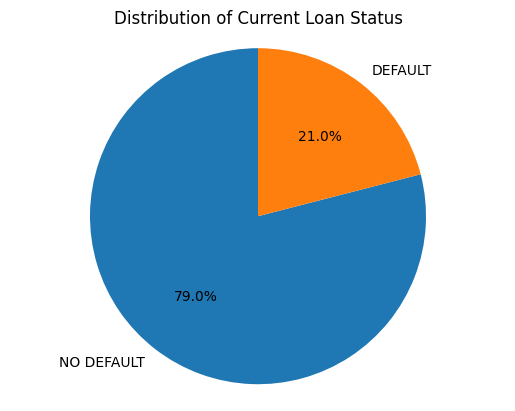

In [82]:
loan_status_counts = df['current_loan_status'].value_counts()

# Create the pie chart
plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

plt.title('Distribution of Current Loan Status')
plt.show()


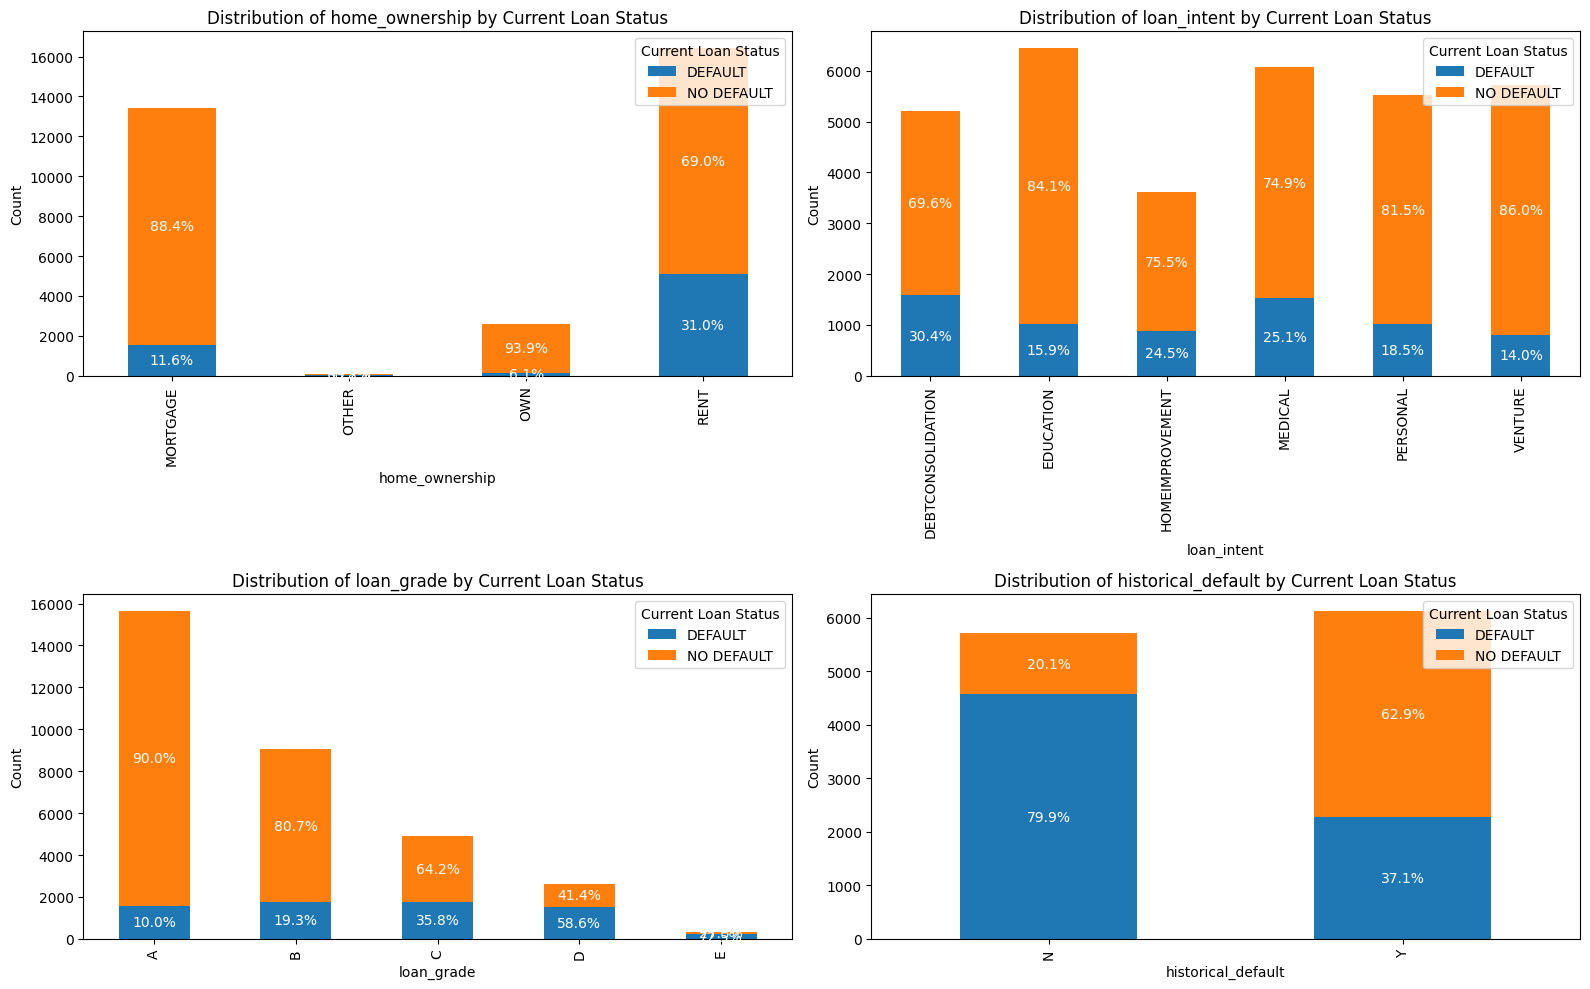

In [83]:
categorical_columns = ['home_ownership', 'loan_intent', 'loan_grade', 'historical_default']
num_columns = len(categorical_columns)
num_rows = math.ceil(num_columns / 2)

plt.figure(figsize=(16, 10))

for i, column_name in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, 2, i)

    # Calculate the counts and percentages
    data = df.groupby([column_name, 'current_loan_status']).size().unstack().fillna(0)
    percentages = data.div(data.sum(axis=1), axis=0)

    # Plot the stacked bar chart with counts
    ax = data.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#1f77b4', '#ff7f0e'])

    # Annotate bars with percentages
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        total = data.sum(axis=1).iloc[int(x + width / 2)]
        percentage = f'{height / total:.1%}'
        ax.annotate(percentage, (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='white')

    plt.title(f'Distribution of {column_name} by Current Loan Status')
    plt.ylabel('Count')
    plt.xlabel(column_name)
    plt.legend(title='Current Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

The next two cells is a display of percentage of people who have default loans and non default loans of the cells that are not visible in the last visual.

In [84]:
# Filter the dataframe for 'other' value in loan_grade column
e_loan_grade = df[df['loan_grade'] == 'E']
# Display the percentage of default/no-default for 'E' value
e_grade_counts = e_loan_grade['current_loan_status'].value_counts() / e_loan_grade.shape[0] * 100

print("The percentage of defaulted loans with E loan grade is {:.2f}%".format(e_grade_counts.iloc[0]))

The percentage of defaulted loans with E loan grade is 72.46%


In [85]:
# Filter the dataframe for 'other' value in home_ownership column
other_home_ownership = df[df['home_ownership'] == 'OTHER']

# Display the percentage of default/no-default for 'other' value
other_counts = other_home_ownership['current_loan_status'].value_counts() / other_home_ownership.shape[0] * 100
print("The percentage of defaulted loans with \"Other\" in home_ownership column is {:.2f}%".format(other_counts.iloc[0]))

The percentage of defaulted loans with "Other" in home_ownership column is 69.16%


<b>Distribution of numerical columns</b>

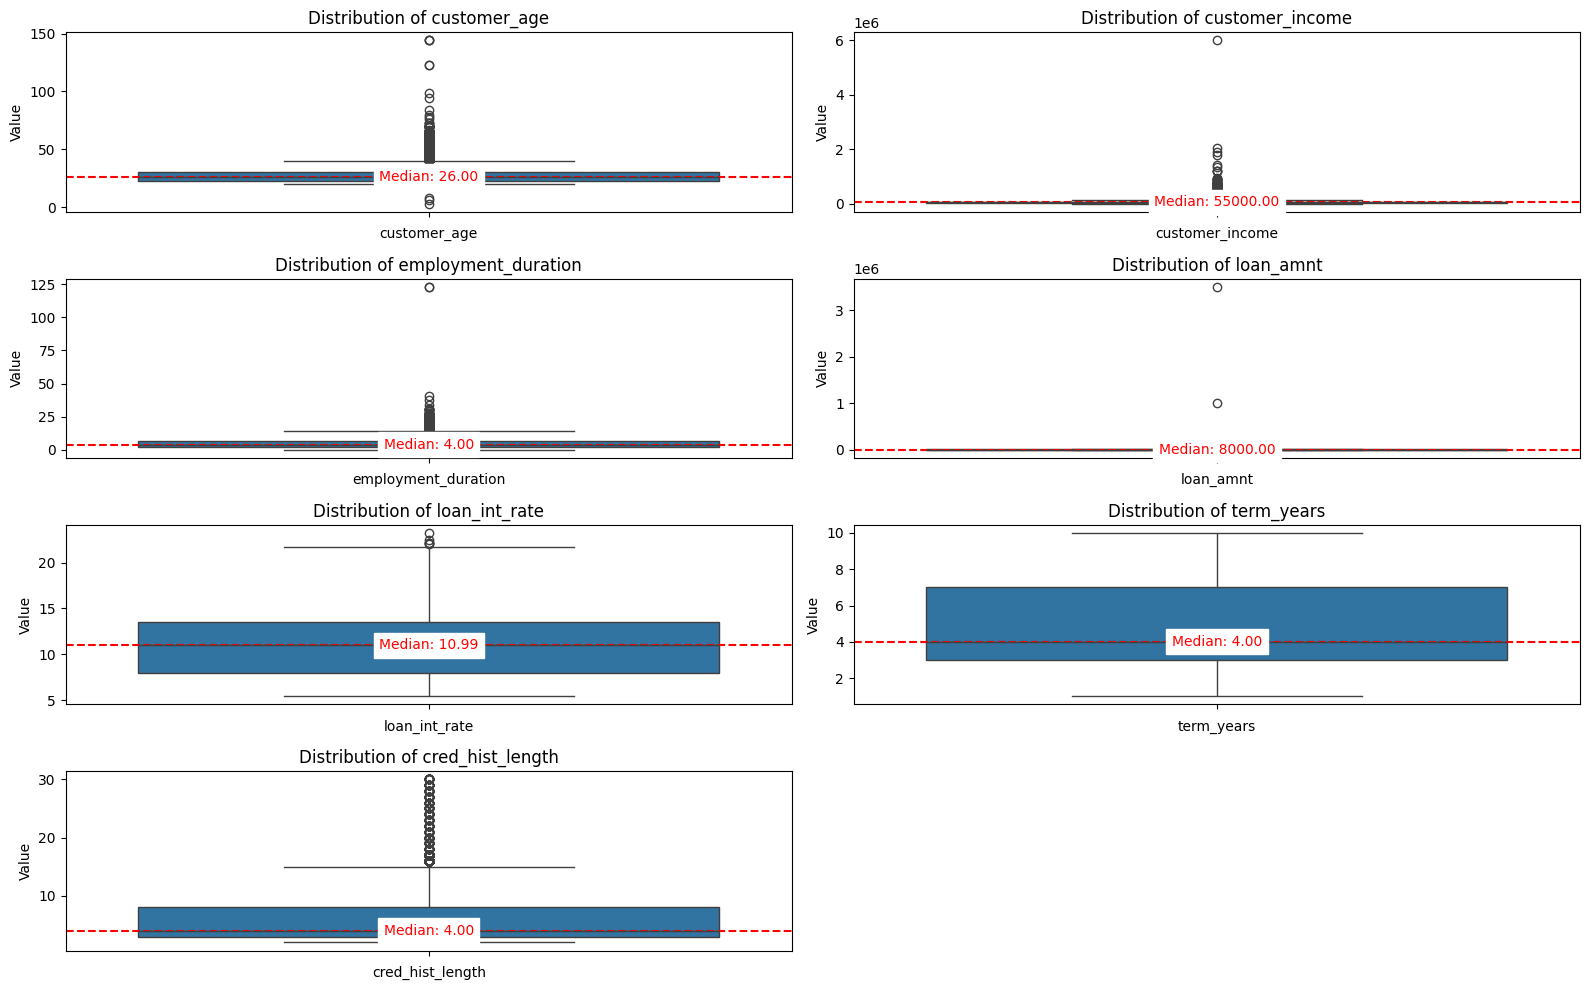

In [86]:
numerical_columns = ['customer_age', 'customer_income', 'employment_duration', 'loan_amnt', 'loan_int_rate', 'term_years', 'cred_hist_length']

plt.figure(figsize=(16, 10))

for i, column_name in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns) // 2 + 1, 2, i)
    ax = sns.boxplot(data=df, y=column_name)

    # Calculate the median
    median = df[column_name].median()

    # Add the median line
    ax.axhline(median, color='r', linestyle='--')

    # Annotate the median value
    ax.annotate(f'Median: {median:.2f}', xy=(0.5, median), xycoords=('axes fraction', 'data'),
                ha='center', va='center', fontsize=10, color='red', backgroundcolor='white')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

- **Customer Age**:  
  - Median age is **26 years**.  
  - Several outliers, with extreme values exceeding **140 years**, suggesting possible data entry errors.  

- **Employment Duration**:  
  - Median duration is **4 years**.  
  - Some extreme outliers, with a few values exceeding **120 years**, indicating data inconsistencies.  

- **Loan Amount**:  
  - Median loan amount is **8,000**.  
  - Extreme outliers exist, with some values reaching **3.5 million**, indicating high variance.  

- **Loan Interest Rate**:  
  - Median interest rate is **10.99%**.  
  - Distribution appears more balanced, with some high outliers beyond **20%**.  

- **Loan Term (Years)**:  
  - Median loan term is **4 years**.  
  - Most values fall within a reasonable range, but there are some variations.  

- **Credit History Length**:  
  - Median credit history length is **4 years**.  
  - Many outliers, with some credit histories extending beyond **25 years**.  

- **Customer Income**:  
  - Median age is 26 with outlier that consist of people below 18 years old and above 80 years old.
  - Median income is 55000£. People who ear over 100000£ can be considered outliers.
  - The median of professional years experience is 4 years. We notice there is one person with 140 years experience.
  - The median of loan amount is 8000. Loan amounts above 100000£ can be considered as outliers.
  - The median loan interest is 11%. Interests above 21% can be considered as outliers.
  - The median payment term is 4 years. No outliers detected.
  - The median of credit history length is 4 years. Values above 15 years can bbe considered as outliers.

### Observations:  
- Several features contain extreme outliers (e.g., customer age, employment duration, loan amount).  
- Potential data quality issues exist, particularly with implausible values (e.g., age > 100 years).  
- Loan amount and credit history length show a highly skewed distribution.  
- Interest rates and loan terms appear relatively well-distributed but still have some high-end variations. 

**Pairplots**

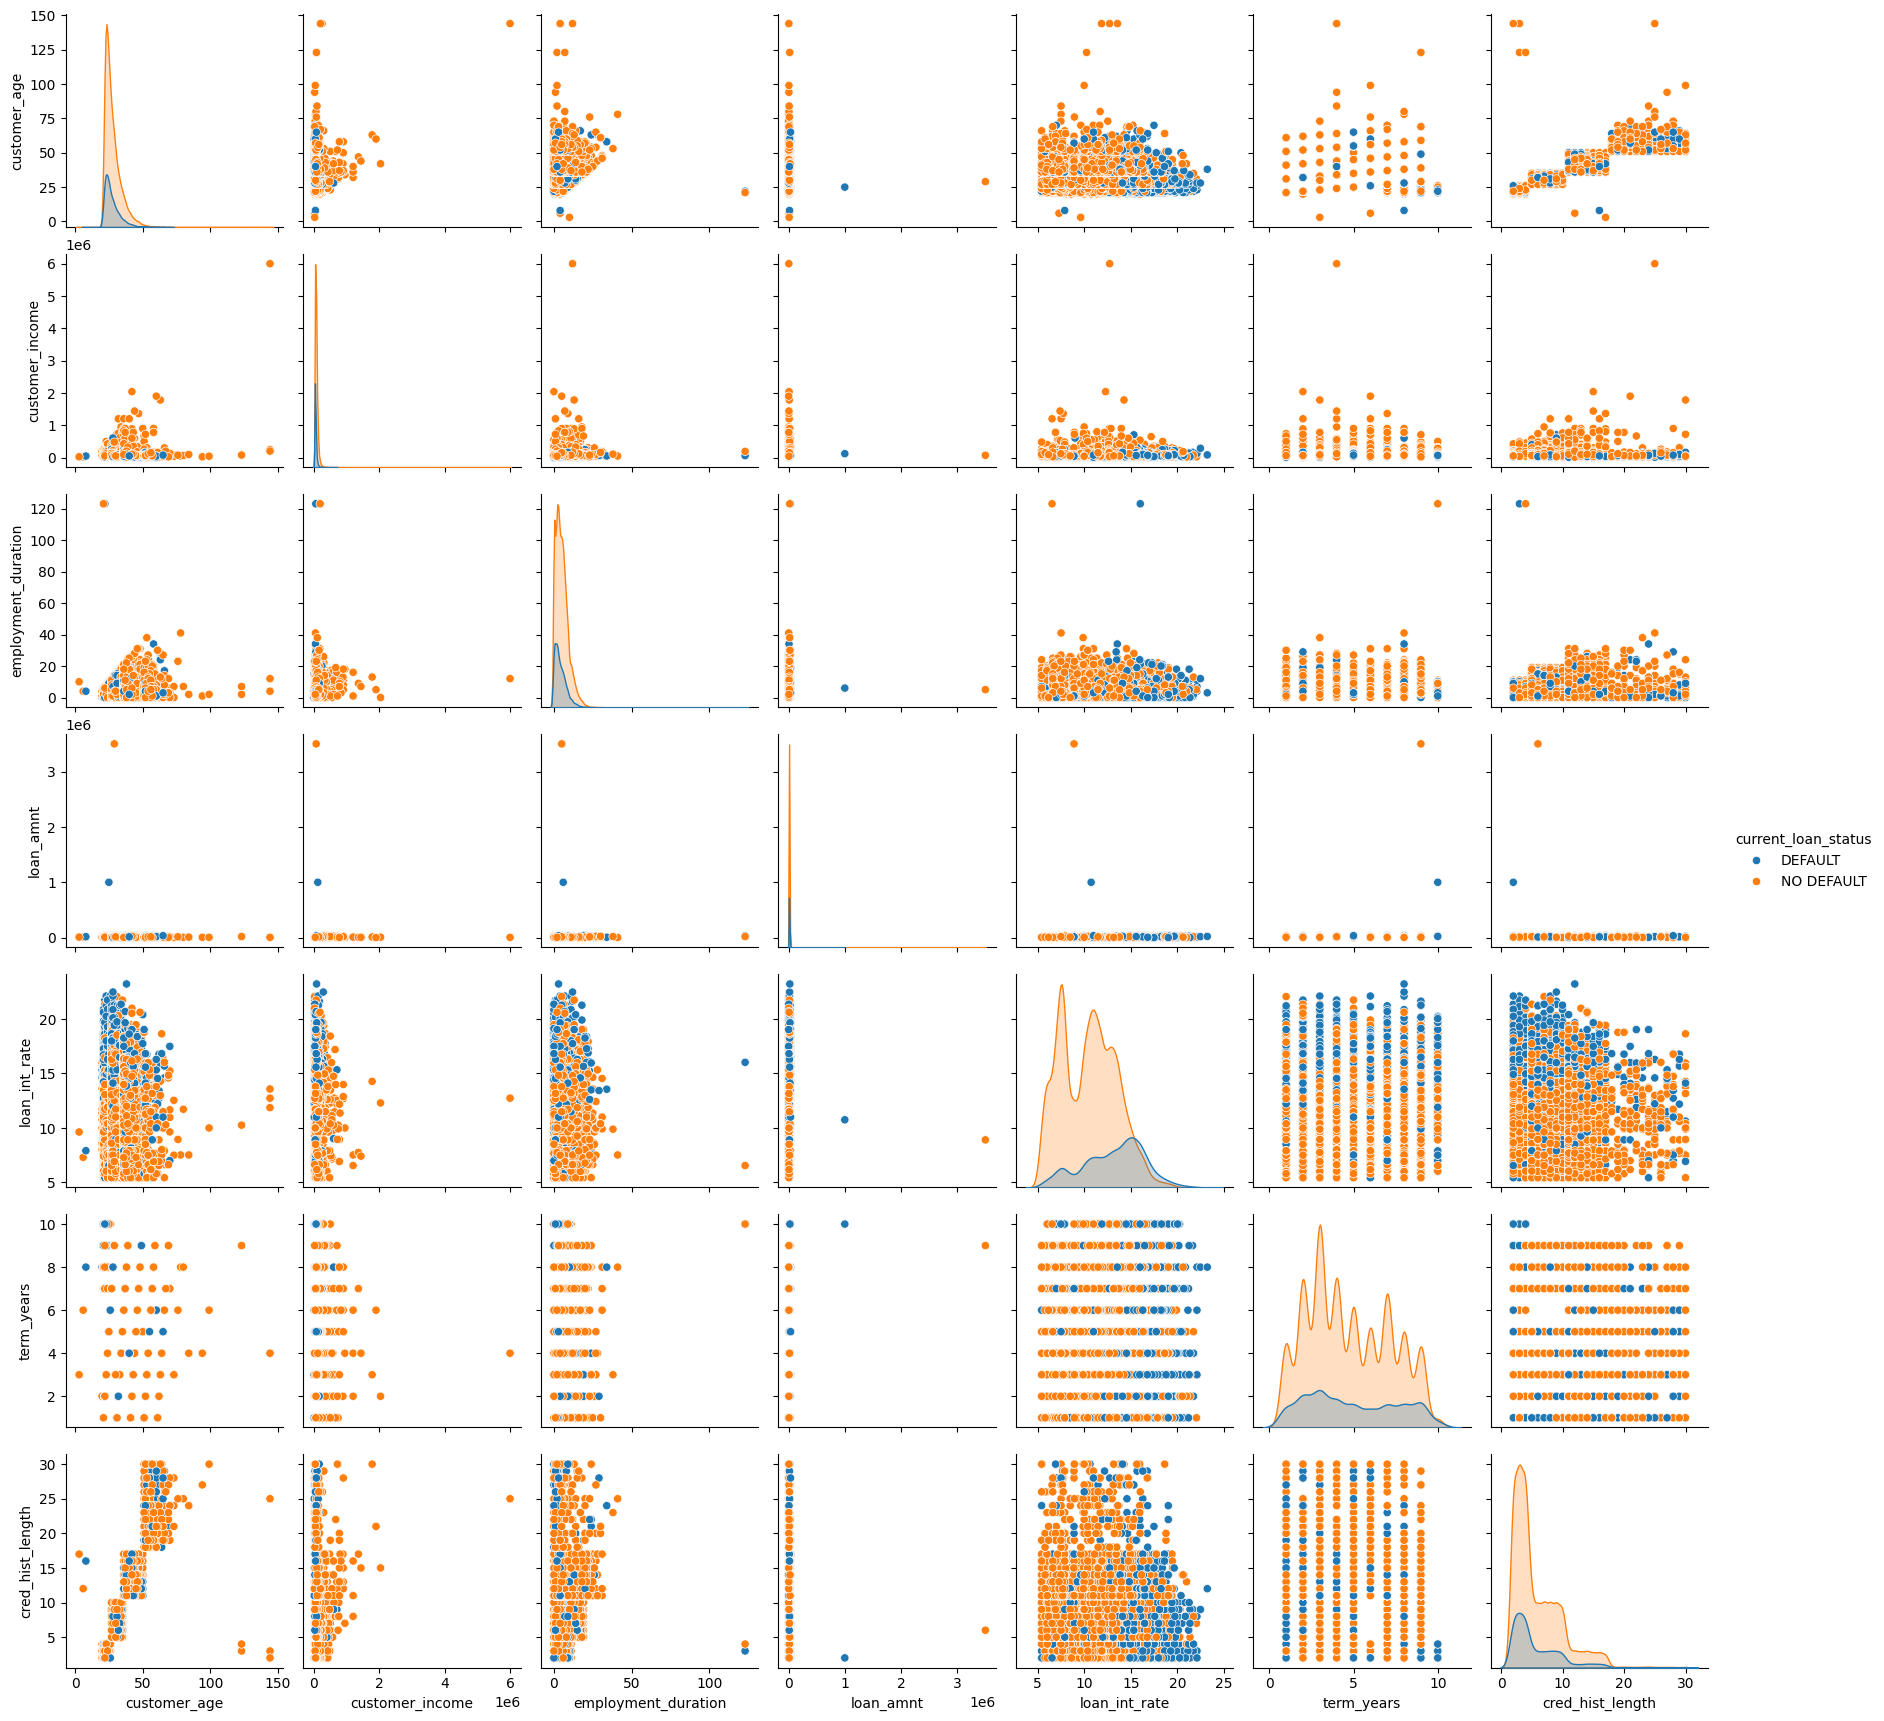

In [87]:
# I create this copy to avoid missing values in customer_income
df_copy = df.copy()

numerical_columns = ['customer_age', 'customer_income', 'employment_duration', 'loan_amnt', 'loan_int_rate', 'term_years', 'cred_hist_length']
sns.pairplot(df_copy, vars=numerical_columns, hue='current_loan_status')
plt.show()

The pairplot of some columns is not visible because of outliers.

I will delete them temporally so we can have a clear distribution.

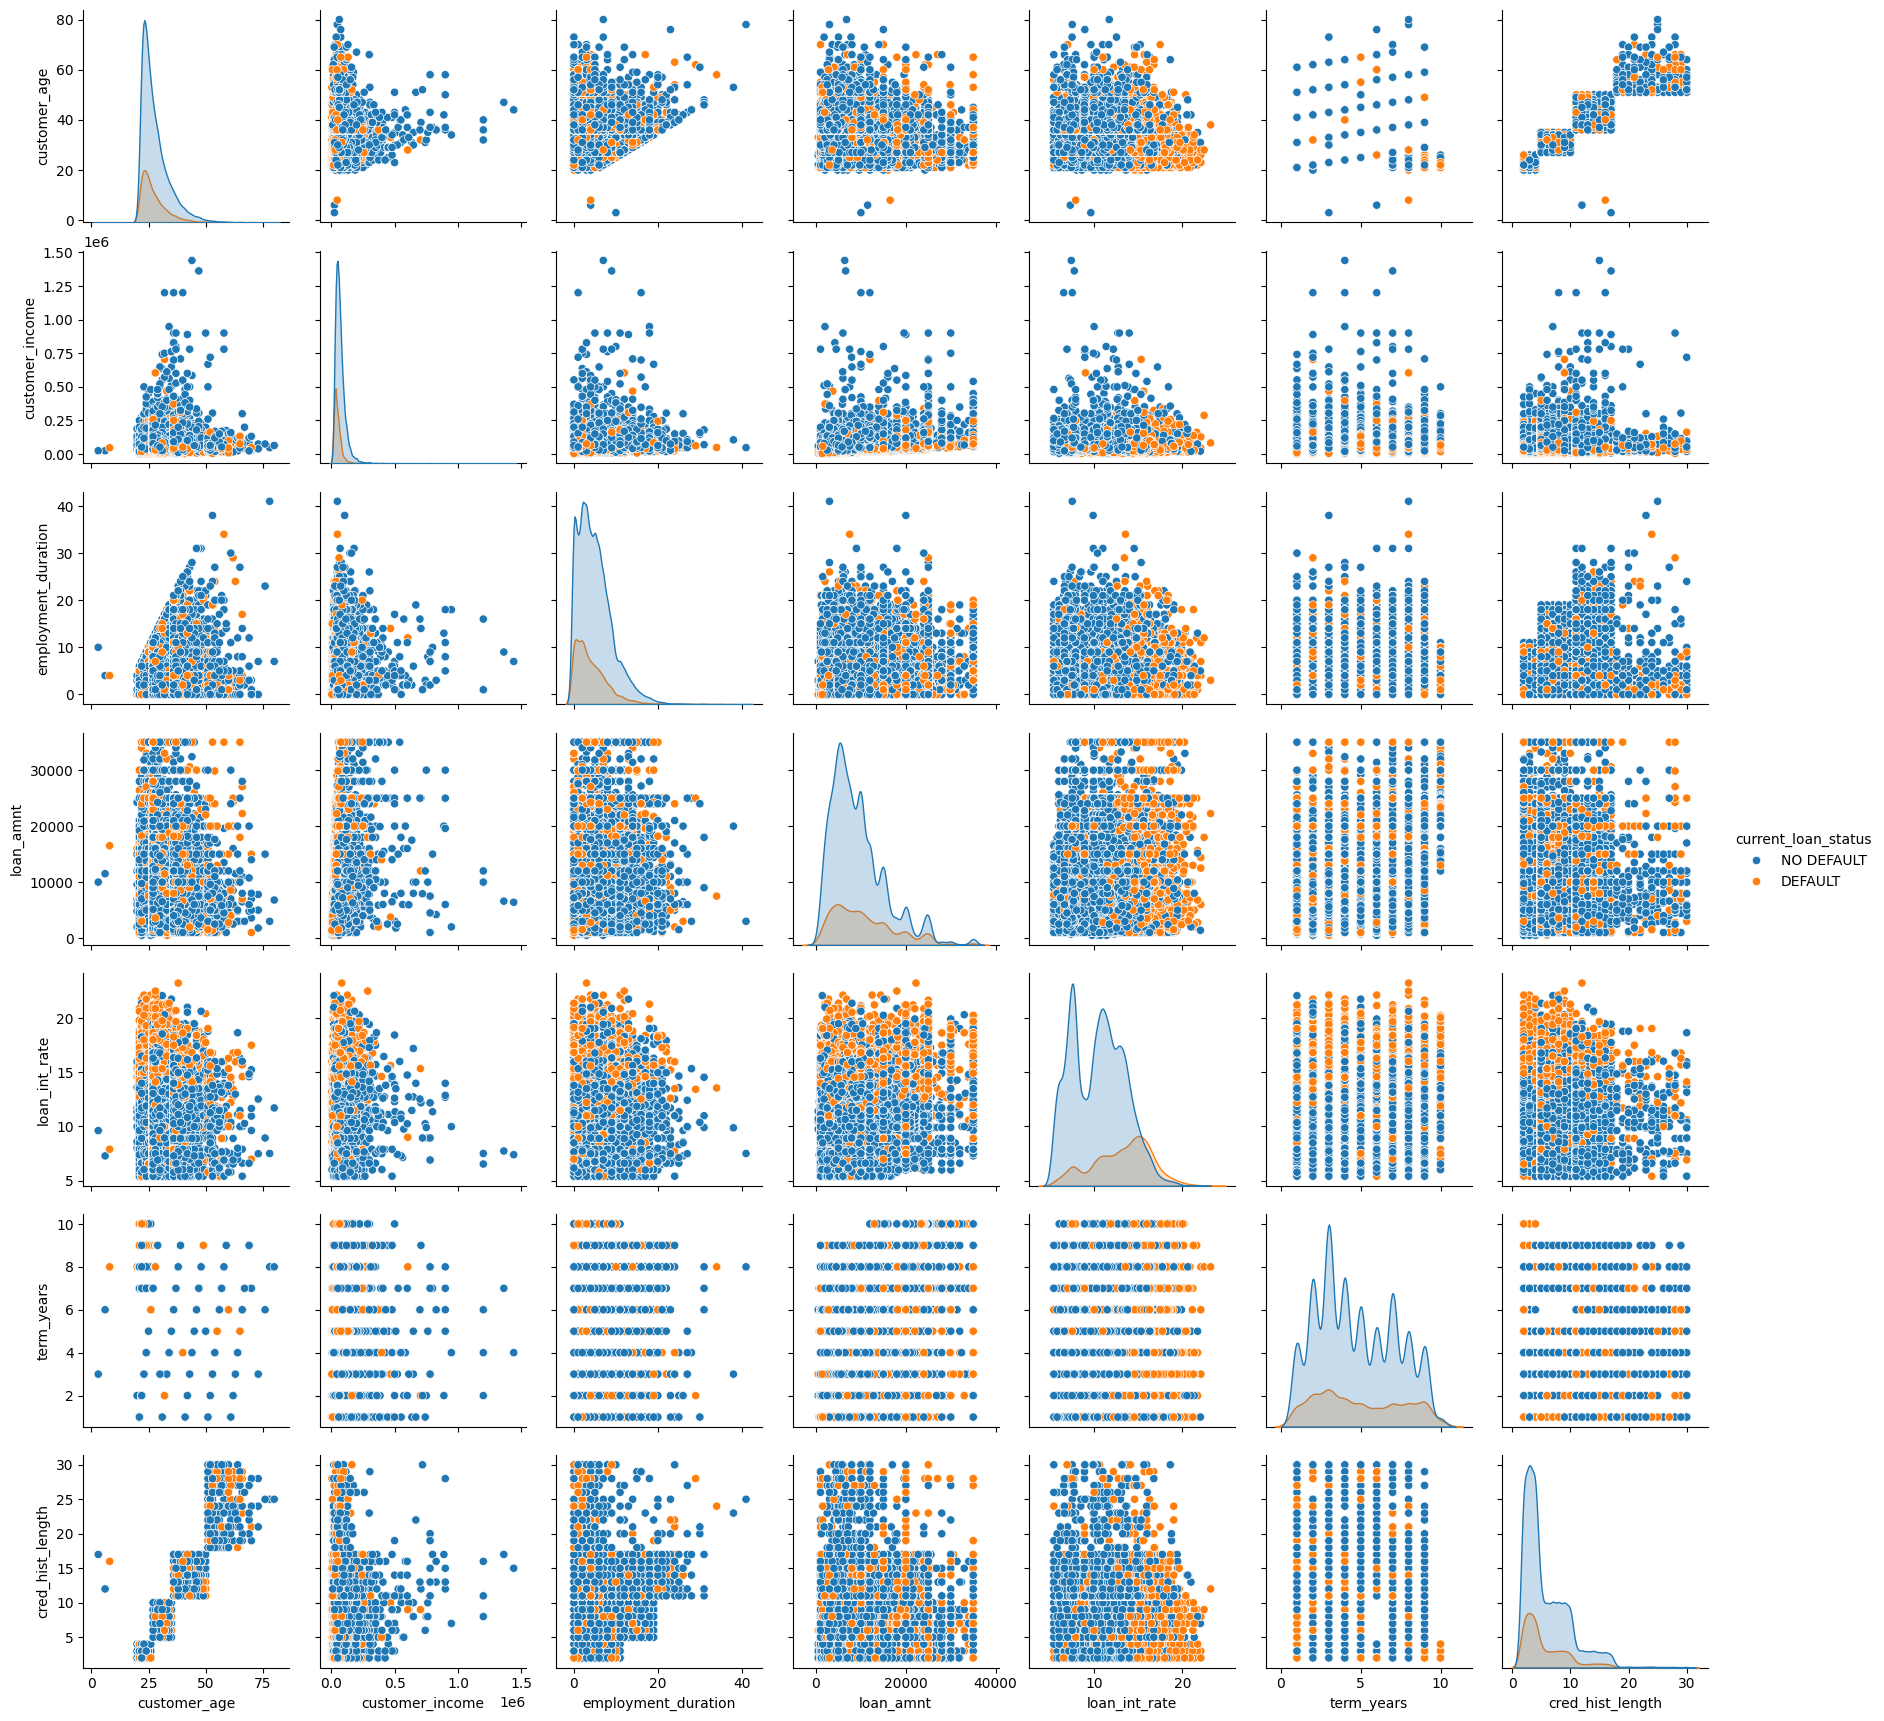

In [88]:
df_copy = df_copy.drop(df_copy['employment_duration'].sort_values(ascending=False).head(2).index, axis=0)
df_copy = df_copy.drop(df_copy['customer_income'].sort_values(ascending=False).head(4).index, axis=0)
df_copy = df_copy.drop(df_copy['loan_amnt'].sort_values(ascending=False).head(3).index, axis=0)
df_copy = df_copy.drop(df_copy['customer_age'].sort_values(ascending=False).head(7).index, axis=0)

sns.pairplot(df_copy, vars=numerical_columns, hue='current_loan_status')
plt.show()

<b>Key Insights from Loan Default Analysis</b>

**Strong Correlations**
- **Credit History Length & Age**: Strong positive relationship
- **Interest Rate & Default Risk**: Higher interest rates show increased default probability

**Default Risk Factors**
1. **Age Distribution**:
  - Default cases cluster in younger age groups (25-40)
  - More stable repayment history in 40+ age group

2. **Income Patterns**:
  - Defaults more common in lower-middle income brackets
  - High income borrowers show lower default rates
  - Some outliers in high-income defaults warrant investigation

3. **Employment Duration**:
  - Higher defaults in 0-5 years employment duration
  - Stable employment (10+ years) correlates with lower defaults

4. **Loan Terms**:
  - Short-term loans (2-5 years) show mixed default patterns
  - Long-term loans (7+ years) have more consistent repayment

5. **Credit History**:
  - Longer credit history strongly correlates with lower defaults
  - Critical threshold appears around 10 years of credit history

<b>Business Implications</b>
- Focus risk assessment on younger borrowers with shorter credit history
- Consider employment duration heavily in loan approval process
- Potential for tiered interest rates based on credit history length
- Review high-income default cases for potential fraud patterns

<b>Data Quality Notes</b>
- Some outliers in income and loan amount need validation
- Employment duration shows discrete clustering
- Interest rate distribution suggests standardized rate tiers

debt to income

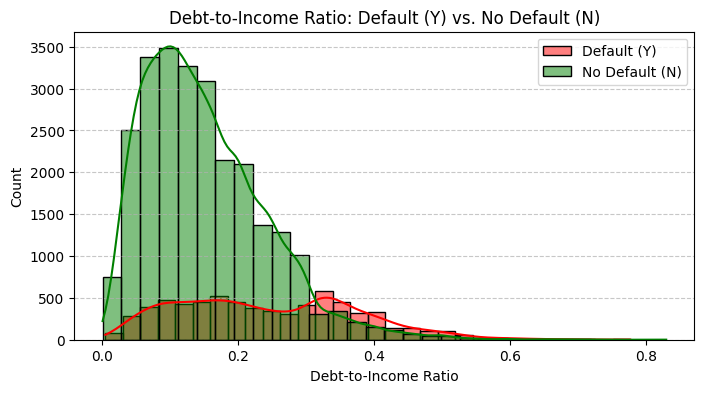

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
df_copy['debt_to_income'] = df_copy['loan_amnt'] / df_copy['customer_income']

# Plot histograms for each class
sns.histplot(
    data=df_copy[df_copy['current_loan_status'] == 'DEFAULT'],  # Defaults
    x='debt_to_income',
    color='red',
    label='Default (Y)',
    kde=True,
    alpha=0.5,  # Transparency
    bins=30
)

sns.histplot(
    data=df_copy[df_copy['current_loan_status'] == 'NO DEFAULT'],  # Non-defaults
    x='debt_to_income',
    color='green',
    label='No Default (N)',
    kde=True,
    alpha=0.5,
    bins=30
)

plt.title('Debt-to-Income Ratio: Default (Y) vs. No Default (N)')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

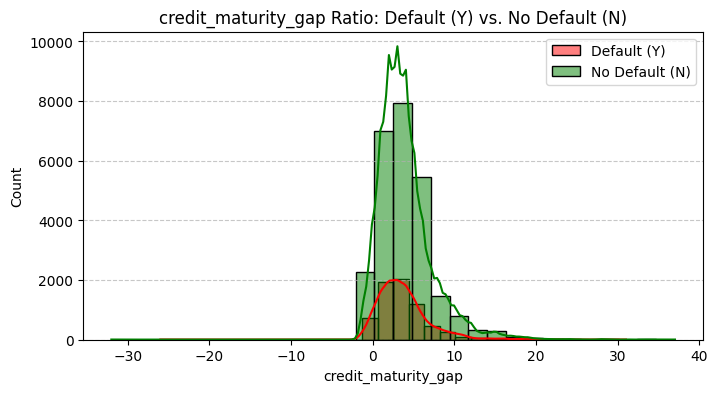

In [90]:
plt.figure(figsize=(8, 4))
df_copy['credit_maturity_gap'] = df_copy['customer_age'] - df_copy['cred_hist_length'] - 18

# Plot histograms for each class
sns.histplot(
    data=df_copy[df_copy['current_loan_status'] == 'DEFAULT'],  # Defaults
    x='credit_maturity_gap',
    color='red',
    label='Default (Y)',
    kde=True,
    alpha=0.5,  # Transparency
    bins=30
)

sns.histplot(
    data=df_copy[df_copy['current_loan_status'] == 'NO DEFAULT'],  # Non-defaults
    x='credit_maturity_gap',
    color='green',
    label='No Default (N)',
    kde=True,
    alpha=0.5,
    bins=30
)

plt.title('credit_maturity_gap Ratio: Default (Y) vs. No Default (N)')
plt.xlabel('credit_maturity_gap')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

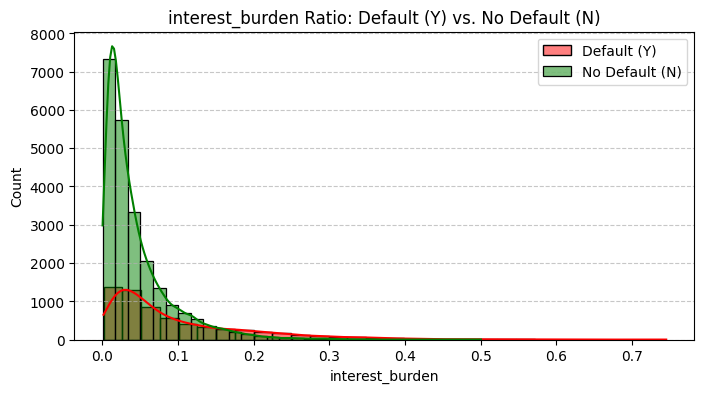

In [91]:
plt.figure(figsize=(8, 4))
df_copy['monthly_payment'] = (df_copy['loan_amnt'] * (df_copy['loan_int_rate']/100/12)) / (1 - (1 + df_copy['loan_int_rate']/100/12)**(-df_copy['term_years']*12))
df_copy['interest_burden'] = (df_copy['monthly_payment'] * df_copy['term_years'] * 12 - df_copy['loan_amnt']) / df_copy['customer_income']

# Plot histograms for each class
sns.histplot(
    data=df_copy[df_copy['current_loan_status'] == 'DEFAULT'],  # Defaults
    x='interest_burden',
    color='red',
    label='Default (Y)',
    kde=True,
    alpha=0.5,  # Transparency
    bins=30
)

sns.histplot(
    data=df_copy[df_copy['current_loan_status'] == 'NO DEFAULT'],  # Non-defaults
    x='interest_burden',
    color='green',
    label='No Default (N)',
    kde=True,
    alpha=0.5,
    bins=30
)

plt.title('interest_burden Ratio: Default (Y) vs. No Default (N)')
plt.xlabel('interest_burden')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<a id="data-cleaning-and-preprocessing"></a>
### Data Cleaning and Preprocessing <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

**Note:** In this analysis, I will only remove the unrealistic values in my dataset like 123 years of experience, 8 years old customer, etc... I am trying to make the model realistic as much as I can.

In [92]:
df_cleaned = df.copy()

Delete customer_id column since it's useless in our analysis.

In [93]:
df_cleaned = df_cleaned.drop(columns=['customer_id'], axis=1)

remove very high loan amount and very high customer_income

In [94]:
df_cleaned = df_cleaned[df_cleaned['loan_amnt'] <= 200000]
df_cleaned = df_cleaned[df_cleaned['customer_income'] <= 1000000]

Removing unrealistic ages or exceptions

In [95]:
df_cleaned = df_cleaned[(df_cleaned['customer_age'] >= 18) & (df_cleaned['customer_age'] <= 80)]

Deleting customer with 123 years of experience

In [ ]:
# Remove rows with the maximum years of experience
df_cleaned = df_cleaned[df_cleaned['employment_duration'] < 34]

In [97]:
df_cleaned.isnull().sum()

customer_age               0
customer_income            0
home_ownership             0
employment_duration      895
loan_intent                0
loan_grade                 0
loan_amnt                  0
loan_int_rate           3111
term_years                 0
historical_default     20724
cred_hist_length           0
current_loan_status        4
dtype: int64

I'm going to drop historical_default column since 63% of it's values is missing which can be noisy for machine learning algorithms.
I'm gonna also delete row with loan_amount = 1 so it doesn't be a problem for machine learning models that are impacted by missing values.

In [98]:
df_cleaned = df_cleaned.drop(columns=['historical_default'], axis=1)
df_cleaned = df_cleaned.dropna(subset=['loan_amnt'])

<b>Encoding/Transforming</b>

**Note:** I started with encoding instead of filling missing values because I am going to use "Iterative Imputer" and "KNN imputer" and these imputers don't accept values with types other than numerics

In [197]:
df_encoded = df_cleaned.copy()
# Perform one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=['loan_intent', 'home_ownership']) #, drop_first=True)

# Encode binary columns
df_encoded['current_loan_status'] = df_encoded['current_loan_status'].map({'NO DEFAULT': 0, 'DEFAULT': 1})

# Encode the ordinal column 'loan_grade'
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
df_encoded['loan_grade'] = df_encoded['loan_grade'].map(grade_mapping)

# Display the first few rows of the encoded dataframe
df_encoded.head()

customer_age  customer_income  employment_duration  loan_grade  loan_amnt  \
1            21           9600.0                  5.0           1     1000.0   
2            25           9600.0                  1.0           2     5500.0   
3            23          65500.0                  4.0           2    35000.0   
4            24          54400.0                  8.0           2    35000.0   
5            21           9900.0                  2.0           1     2500.0   

   loan_int_rate  term_years  cred_hist_length  current_loan_status  \
1          11.14           1                 2                  0.0   
2          12.87           5                 3                  1.0   
3          15.23          10                 2                  1.0   
4          14.27          10                 4                  1.0   
5           7.14           1                 2                  1.0   

   loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
1                          False                   True   
2                          False                  False   
3                          False                  False   
4                          False                  False   
5                          False                  False   

   loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
1                        False                False                 False   
2                        False                 True                 False   
3                        False                 True                 False   
4                        False                 True                 False   
5                        False                False                 False   

   loan_intent_VENTURE  home_ownership_MORTGAGE  home_ownership_OTHER  \
1                False                    False                 False   
2                False                     True                 False   
3                False                    False                 False   
4                False                    False                 False   
5                 True                    False                 False   

   home_ownership_OWN  home_ownership_RENT  
1                True                False  
2               False                False  
3               False                 True  
4               False                 True  
5                True                False

##### Statistical analysis

Next, I will check if missing values are completely random or not by using MCAR_test. If it's completely random then I will use KNN imputation to fill missing values

In [198]:
from pyampute.exploration.mcar_statistical_tests import MCARTest

mt = MCARTest(method="little")
print(mt.little_mcar_test(df_encoded))

0.0


The p-value = 0.0 suggest that data is not missing completely at random.

<b>Filling missing values</b>

For filling missing values, I will use MICE impute strategy since I have a mix between data types (numerical & categorical) and I want to preserves the relationship between variables.

In [200]:
def is_binary_column(series):
    """
    More robust check if a column is binary
    Returns: bool, original_values
    """
    # Drop NA values and get unique values
    unique_vals = pd.Series(series.dropna().unique())

    # Convert to numeric if possible
    if unique_vals.dtype == 'object':
        try:
            unique_vals = pd.to_numeric(unique_vals)
        except:
            pass

    # Check if there are exactly 2 unique values
    is_binary = len(unique_vals) == 2

    # If binary, return the original unique values for later use
    return is_binary, sorted(unique_vals) if is_binary else None

def impute_with_mice(df, target_column, exclude_columns=None, n_iterations=10, random_state=42):
    
    # Create a copy of the dataframe
    df_imputed = df.copy()

    # Initialize exclude_columns if None
    if exclude_columns is None:
        exclude_columns = []

    # Add target_column to exclude_columns if not already present
    if target_column not in exclude_columns:
        exclude_columns = exclude_columns + [target_column]

    # Select features for imputation (excluding target column and specified columns)
    features = [col for col in df_imputed.columns
            if col not in exclude_columns]

    # Check if target column is binary and get original values if it is
    is_binary, binary_values = is_binary_column(df[target_column])

    # Always use RandomForestRegressor for the initial imputation
    estimator = RandomForestRegressor(n_estimators=100, random_state=random_state)

    if is_binary:
        print(f"\nDetected '{target_column}' as binary column with values: {binary_values}")
    else:
        print(f"\nDetected '{target_column}' as continuous column")

    # Initialize MICE imputer
    mice_imputer = IterativeImputer(
        estimator=estimator,
        n_nearest_features=None,
        imputation_order='random',
        max_iter=n_iterations,
        random_state=random_state
    )

    # Store original missing value locations
    missing_mask = df_imputed[target_column].isna()

    # Create feature matrix for imputation
    X = df_imputed[features].copy()
    y = df_imputed[target_column].copy()

    # Convert target to numeric if possible
    if y.dtype == 'object':
        try:
            y = pd.to_numeric(y)
        except:
            raise ValueError(f"Column {target_column} cannot be converted to numeric format")

    # Create a temporary DataFrame for imputation
    temp_df = pd.concat([X, y], axis=1)

    # Perform imputation
    imputed_values = mice_imputer.fit_transform(temp_df)

    # Create DataFrame with imputed values
    df_imputed = pd.DataFrame(imputed_values, columns=temp_df.columns, index=df_imputed.index)

    # If binary, convert imputed values back to original binary values
    if is_binary:
        threshold = np.mean(binary_values)
        df_imputed[target_column] = np.where(
            df_imputed[target_column] >= threshold,
            binary_values[1],
            binary_values[0]
        )

    # Restore excluded columns
    for col in exclude_columns:
        if col != target_column:
            df_imputed[col] = df[col]

    

    return df_imputed

# Example usage
for col in ['loan_int_rate', 'employment_duration']:
    df_encoded = impute_with_mice(
        df_encoded,
        target_column=col,
        exclude_columns=['current_loan_status']
    )


Detected 'loan_int_rate' as continuous column

Detected 'employment_duration' as continuous column


<b>Isolating missing "current_loan_status" rows and Creating dataframe for training</b>

In [201]:
df_missing = df_encoded[df_encoded.isnull().any(axis=1)]
df_train = df_encoded.dropna()

<a id="#feature-engineering"></a>
### Feature Engineering <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [231]:
# def feature_engineering(data):    
#     # 5. Feature engineering: Create new features to capture more complex relationships
#     # and potentially improve model performance for loan default prediction.
#     print("\n5. Feature engineering...")
    
#     # Debt-to-income ratio: Indicates a borrower's ability to manage monthly payments.
#     # Higher values suggest a larger portion of income is used for debt, implying higher risk of default.
#     data.loc[:, 'debt_to_income'] = data['loan_amnt'] / data['customer_income']
    
#     # Interest coverage ratio: Measures a borrower's ability to pay interest expenses.
#     # A lower ratio indicates less income available to cover interest, suggesting higher risk.
#     data.loc[:, 'interest_coverage'] = data['customer_income'] / (data['loan_amnt'] * data['loan_int_rate'])
    
#     # Monthly payment calculation: Estimates the fixed monthly payment for the loan.
#     # This is a fundamental metric for assessing a borrower's financial burden.
#     data.loc[:, 'monthly_payment'] = (data['loan_amnt'] * (data['loan_int_rate']/100/12)) / (1 - (1 + data['loan_int_rate']/100/12)**(-data['term_years']*12))
    
#     # Interest burden: Represents the total interest paid relative to customer income over the loan term.
#     # A higher burden implies a greater financial strain, increasing default risk.
#     data.loc[:, 'interest_burden'] = (data['monthly_payment'] * data['term_years'] * 12 - data['loan_amnt']) / data['customer_income']
    
#     # Grade risk: An interaction feature between loan grade and interest rate.
#     # This amplifies the risk for loans with higher grades (indicating higher risk) and higher interest rates.
#     data.loc[:, 'grade_risk'] = data['loan_grade'] * data['loan_int_rate']
    
#     # Income stability: Log-transformed income divided by employment duration.
#     # A higher value suggests more stable income relative to employment history, potentially lowering default risk.
#     data.loc[:, 'income_stability'] = np.log1p(data['customer_income']) / (data['employment_duration'] + 1)
    
#     # Payment shock risk: Measures the potential impact of interest rate changes over the loan term.
#     # A higher value indicates greater sensitivity to interest rate fluctuations, increasing risk.
#     data.loc[:, 'payment_shock_risk'] = (data['loan_int_rate'] - 5.0) * data['term_years']
    
#     # Emergency buffer: Indicates financial resilience by comparing income after monthly payments to the loan amount.
#     # A larger buffer suggests better capacity to handle unexpected expenses, reducing default risk.
#     data.loc[:, 'emergency_buffer'] = (data['customer_income'] - data['monthly_payment']*12) / data['loan_amnt']
    
#     return data


def feature_engineering(df):   
    print("\n5. Feature engineering...")
    data = df.copy()
    
    # Create debt-to-income ratio
    data.loc[:, 'debt_to_income'] = data['loan_amnt'] / data['customer_income']
    # data['income_employment_interaction'] = data['customer_income'] * data['employment_duration']
    # data['interest_coverage'] = data['customer_income'] / (data['loan_amnt'] * data['loan_int_rate'])
    # data.loc[:, 'loan_to_income'] = data['loan_amnt'] / (data['customer_income'] * data['term_years']) 
    # 2. Payment Burden (Monthly payment as % of income)
    data.loc[:, 'monthly_payment'] = (data['loan_amnt'] * (data['loan_int_rate']/100/12)) / (1 - (1 + data['loan_int_rate']/100/12)**(-data['term_years']*12))
    data.loc[:, 'disposable_income'] = data['customer_income'] -(data['monthly_payment'] * 12)
    data.loc[:, 'payment_burden'] = data['monthly_payment'] / (data['customer_income']/12)    
    # 3. Credit Age Ratio (How long credit history relative to age)
    data.loc[:, 'credit_age_ratio'] = data['cred_hist_length'] / data['customer_age']   
    # 5. Interest Burden (Total interest over loan amount)
    data.loc[:, 'interest_burden'] = (data['monthly_payment'] * data['term_years'] * 12 - data['loan_amnt']) / data['customer_income']
    # 6. Income Adequacy After Loan
    data.loc[:, 'income_after_loan'] = (data['customer_income']/12 - data['monthly_payment']) * 12
    # 8. Employment Stability Flag
    data.loc[:, 'employment_stable'] = np.where(data['employment_duration'] >= 2, 1, 0)
    
    # 1. Risk Amplification
    data.loc[:, 'grade_risk'] = data['loan_grade'] * data['loan_int_rate']
    
    # 3. Behavioral Interactions
    data.loc[:, 'income_stability'] = np.log1p(data['customer_income']) / (data['employment_duration'] + 1)
    # data.loc[:, 'credit_maturity_gap'] = data['customer_age'] - data['cred_hist_length'] - 18
    
    # 4. Loan Structure Risks
    data.loc[:, 'interest_frontload'] = (data['loan_int_rate'] * data['loan_amnt']) / data['term_years']
    data.loc[:, 'payment_shock_risk'] = (data['loan_int_rate'] - 5.0) * data['term_years']
    
    # 5. Financial Buffers
    data.loc[:, 'emergency_buffer'] = (data['customer_income'] - data['monthly_payment']*12) / data['loan_amnt']
    
    # 6. Age Modifiers
    data.loc[:, 'age_risk_modifier'] = np.where(
        data['customer_age'] < 30, 1.5, 
        np.where(data['customer_age'] > 55, 1.2, 1.0)
    )

    return data


In [232]:
# Apply feature engineering
df_encoded_v2 = feature_engineering(df_train)


5. Feature engineering...


In [233]:
columns_to_remove = [
    'loan_intent_EDUCATION',
    'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL',
    'loan_intent_PERSONAL',
    'loan_intent_VENTURE',
    'home_ownership_OWN',
    'home_ownership_RENT',
    'home_ownership_MORTGAGE',
    'home_ownership_OTHER',
    'age_risk_modifier',
    'current_loan_status',
    'loan_grade',
    'employment_stable'
]

tmp = df_encoded_v2.copy()

for col in tmp.columns:
    if col not in columns_to_remove:
        tmp[col] = np.log1p(tmp[col])


for col in ['emergency_buffer', 'interest_burden', 'payment_burden']:
    income_99th = tmp[col].quantile(0.999)
    tmp = tmp[tmp[col] < income_99th]


df_encoded_v2 = tmp

In [234]:
# ## TODO: delete this block later
# df_encoded_v2 = df_encoded_v2[df_encoded_v2['home_ownership_OTHER'] == 0]
# df_encoded_v2 = df_encoded_v2[df_encoded_v2['loan_grade'] < 5]
# df_encoded_v2.drop(columns=['home_ownership_OTHER'], axis=1, inplace=True)

<a id="feature-selection"></a>
### Feature Selection <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [235]:
import importlib
import utils.ml_functions  # Import first
importlib.reload(utils.ml_functions)  # Force-reload
from utils.ml_functions import comprehensive_feature_selection

print("=== LOAN DEFAULT RISK FACTOR OPTIMIZATION ===")
print("Objective: Identify the most predictive borrower characteristics")
print("Business Goal: Maximize default detection while maintaining model simplicity\n")

# Apply feature selection with error handling
selected_features = comprehensive_feature_selection(df_encoded_v2.drop(columns=['current_loan_status'], axis=1), df_encoded_v2['current_loan_status'])

=== LOAN DEFAULT RISK FACTOR OPTIMIZATION ===
Objective: Identify the most predictive borrower characteristics
Business Goal: Maximize default detection while maintaining model simplicity

Starting comprehensive feature selection...
Removing 7 highly correlated features
Selected 25 features out of 25


<a id="model-building-after-fe"></a>
### Model Building And Evaluation <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [236]:
# # Isolate missing rows with missing target values
# df_missing_2 = df_encoded_v2[df_encoded_v2.isnull().any(axis=1)]
# df_train_2 = df_encoded_v2.dropna()

# Prepare the data for training
y_new = df_encoded_v2['current_loan_status']
X_new = selected_features

In [237]:
X_train, X_temp, y_train, y_temp = train_test_split(X_new, y_new, test_size=0.4, random_state=42, stratify=y_new)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [238]:
from utils.ml_functions import create_overfitting_aware_ml_pipeline  # Re-import

# This code will get machine learning models from the file if it exists
# model_filepath = 'models/results.pkl'
# if not os.path.exists(model_filepath):
#     results = joblib.load(model_filepath)
# else:
results = create_overfitting_aware_ml_pipeline(
            X_train, X_val, X_test,
            y_train, y_val, y_test,
            time_budget_minutes=15,
            beta=1,
            cv_folds=5,
            overfitting_tolerance=0.05,  # Max 3% overfitting gap
            overfitting_penalty_weight=0.5  # Penalty strength
        )

OVERFITTING-AWARE ML PIPELINE - ENHANCED OPTIMIZATION
Overfitting tolerance: 0.050
Overfitting penalty weight: 0.5
Class distribution (Train): [0.7913307 0.2086693]
Class weights: {0: np.float64(0.6318470924195223), 1: np.float64(2.3961358602018215)}
Scale pos weight (for XGBoost): 3.792
Using F-beta score with beta=1 (favoring recall)
\nTime budget: 15 minutes (5.0 min per model)
Using cost-sensitive learning instead of synthetic sampling for better generalization

🔍 Using overfitting-aware optimization with 5-fold CV
\n==================== XGBOOST OPTIMIZATION ====================


   0%|          | 00:00/05:00

XGBoost Best F-beta: 0.7696 (from 154 trials)
\n==================== LIGHTGBM OPTIMIZATION ====================


   0%|          | 00:00/05:00

LightGBM Best F-beta: 0.7693 (from 271 trials)
\n==================== RANDOMFOREST OPTIMIZATION ====================


   0%|          | 00:00/05:00

RandomForest Best F-beta: 0.6742 (from 81 trials)

OVERFITTING ANALYSIS OF BEST TRIALS
XGBoost:
  Best penalized score: 0.7696
  Validation score: 0.7700
  Overfitting gap: 0.0508 ⚠️ OVERFITTING
LightGBM:
  Best penalized score: 0.7693
  Validation score: 0.7696
  Overfitting gap: 0.0507 ⚠️ OVERFITTING
RandomForest:
  Best penalized score: 0.6742
  Validation score: 0.6742
  Overfitting gap: 0.0045 ✅ CONTROLLED
\n==================== MODEL TRAINING ====================
Training RandomForest on original data (size: 19471)
Training XGBoost on original data (size: 19471)
Training LightGBM on original data (size: 19471)
\n==================== MODEL EVALUATION ====================
Evaluating models on independent Validation Set for model selection.
\nEvaluating RandomForest on validation set...
  CV F-beta: 0.6742
  Validation F-beta: 0.6720
  Validation Precision: 0.9367
  Validation Recall: 0.5240
  Validation AUC: 0.8851
  Overfitting (CV - Val F-beta): 0.0022 ✅
\nEvaluating XGBoost on v

In [239]:
## Checking for overfitting
from utils.ml_functions import overfitting_check

for model_name in ['best_single_model', 'ensemble']:
    overfitting_check(results[model_name], 1, X_train, y_train, X_val, y_val, X_test, y_test)

\n==================================================
OVERFITTING ANALYSIS
ACCURACY:
  Train: 0.9370
  Val:   0.9410 (diff: -0.0040)
  Test:  0.9311 (diff: +0.0099)
  ✅ Good generalization

PRECISION:
  Train: 0.9513
  Val:   0.9568 (diff: -0.0054)
  Test:  0.9290 (diff: +0.0277)
  ✅ Good generalization

RECALL:
  Train: 0.7359
  Val:   0.7513 (diff: -0.0154)
  Test:  0.7253 (diff: +0.0260)
  ✅ Good generalization

F1:
  Train: 0.8299
  Val:   0.8417 (diff: -0.0118)
  Test:  0.8146 (diff: +0.0271)
  ✅ Good generalization

AUC:
  Train: 0.9591
  Val:   0.9649 (diff: -0.0057)
  Test:  0.9436 (diff: +0.0212)
  ✅ Good generalization

\n==================================================
OVERFITTING ANALYSIS
ACCURACY:
  Train: 0.9348
  Val:   0.9405 (diff: -0.0057)
  Test:  0.9316 (diff: +0.0089)
  ✅ Good generalization

PRECISION:
  Train: 0.9469
  Val:   0.9558 (diff: -0.0089)
  Test:  0.9268 (diff: +0.0290)
  ✅ Good generalization

RECALL:
  Train: 0.7285
  Val:   0.7498 (diff: -0.0213)
  

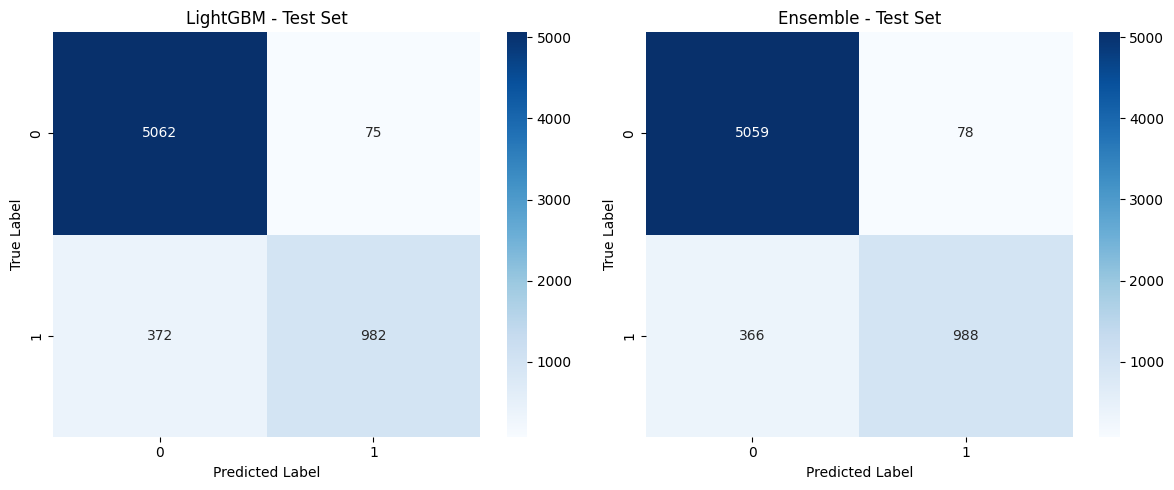

In [240]:
from utils.ml_functions import confusion_matrix_analysis

confusion_matrix_analysis(results, X_test, y_test)

**Why Recall Drops When Improving Your Model:**

1. Overfitting-Recall Tradeoff:
   - Overfitted models achieve high recall by memorizing training patterns, but generalize poorly
   - Regularization prevents overfitting but makes models more conservative, increasing false negatives
   - This conservatism reduces both recall AND precision simultaneously

2. F-beta Optimization Paradox:
   - Higher F-beta values prioritize recall, pushing models to overfit training patterns
   - When you then apply regularization to prevent overfitting:
     * Model becomes more cautious in predictions
     * Fewer true positives are caught (lower recall)
     * Fewer positive predictions overall (lower precision)
   - The model gets caught between overfitting (high train recall) and generalization (lower test recall)

<u>Key Insight:</u>
Regularization necessary for generalization inherently conflicts with recall maximization. 
Improving model robustness often requires accepting lower recall to avoid overfitting.

<a id="model-evaluation-after-fe"></a>
### Model Evaluation In Business Context <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

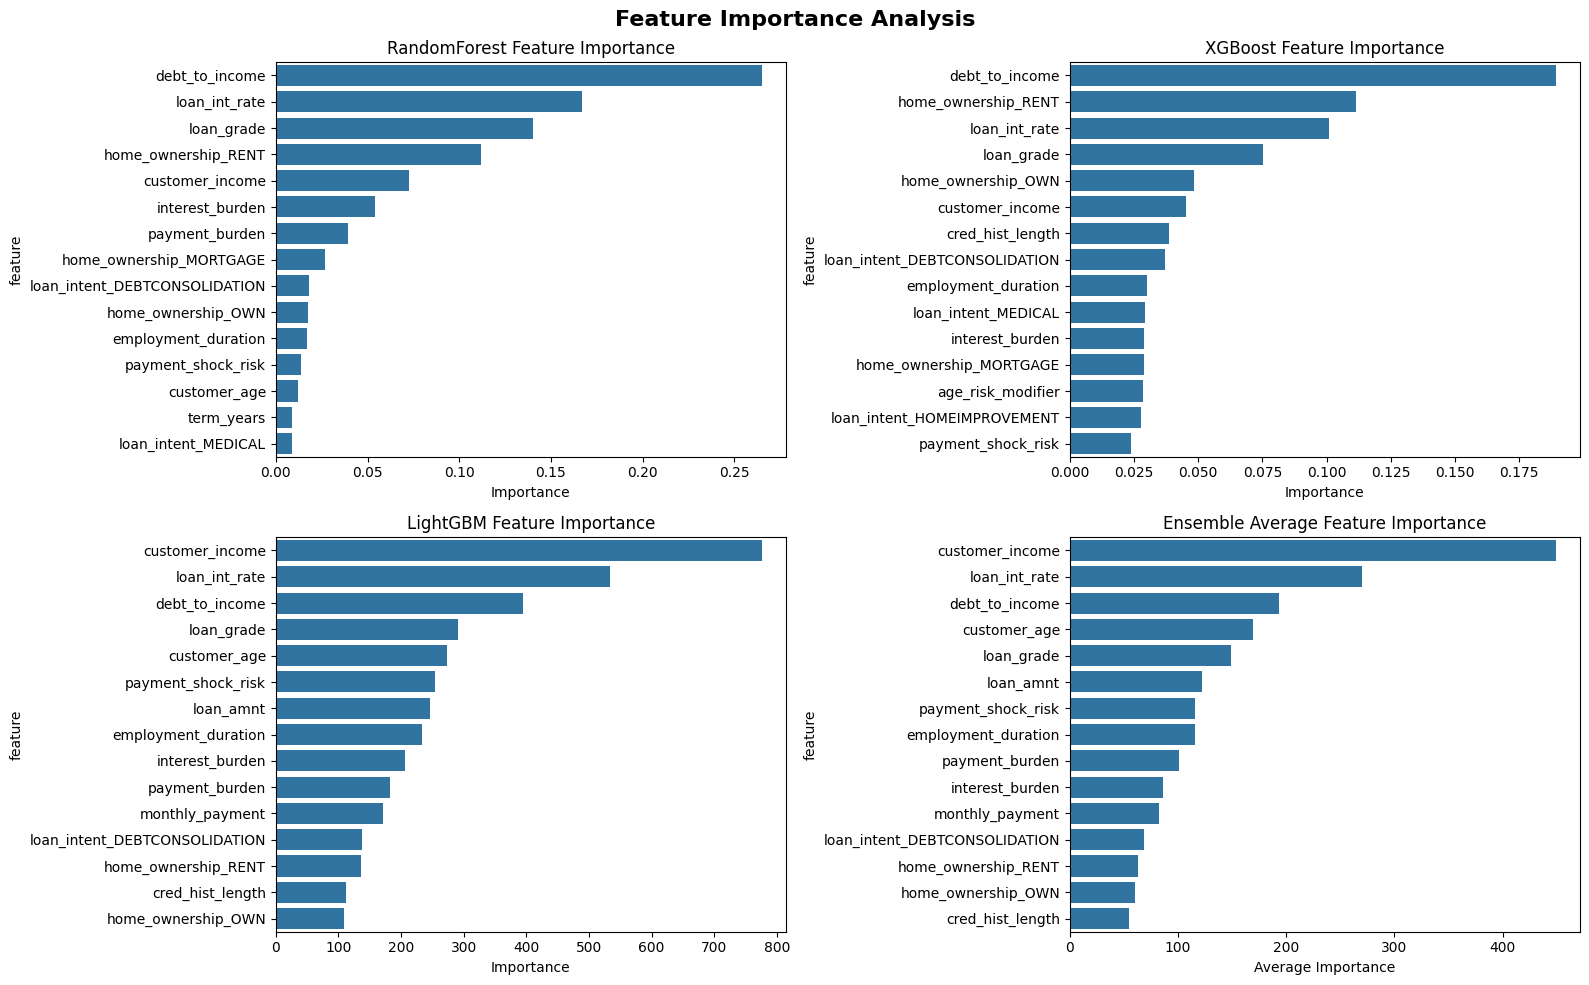

In [241]:
## Feature importance

from utils.ml_functions import plot_feature_importance

plot_feature_importance(
    results['results'],
    results['ensemble'],
    X_test
)

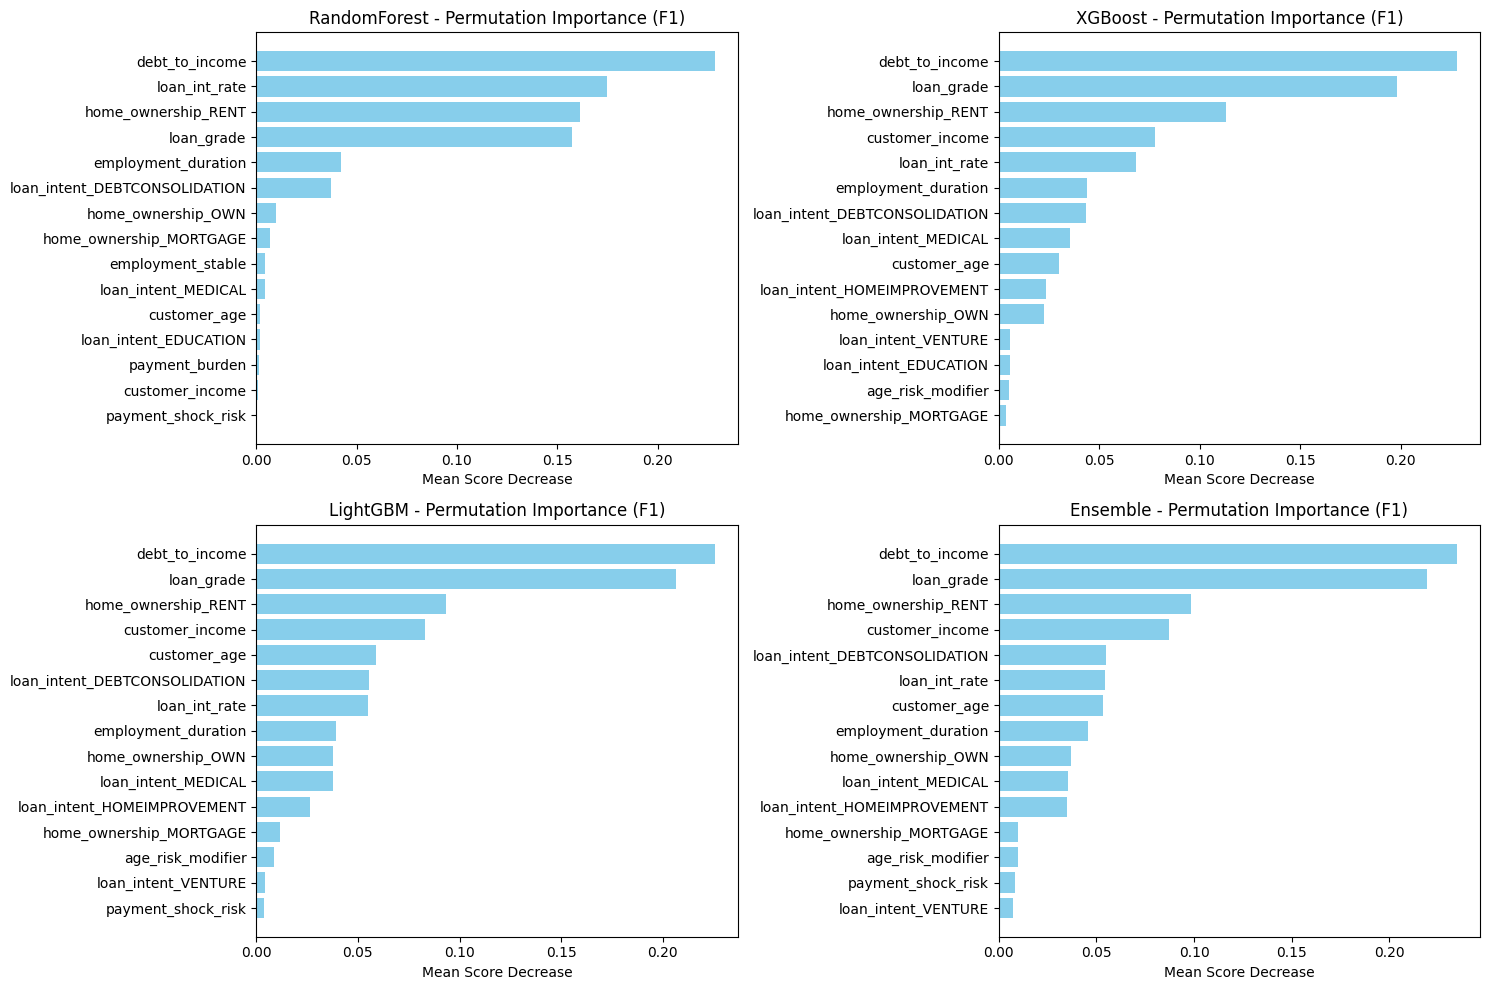

In [ ]:
from utils.ml_functions import plot_permutation_importance

plot_permutation_importance(
    results['results'],
    results['ensemble'],
    X_val,
    y_val,
)

Auto-detected model type: tree
Fast mode: Using 300 samples instead of 6491
Computing SHAP values...
✅ SHAP computation completed in 0.0 seconds
GLOBAL FEATURE IMPORTANCE (TREE MODEL)


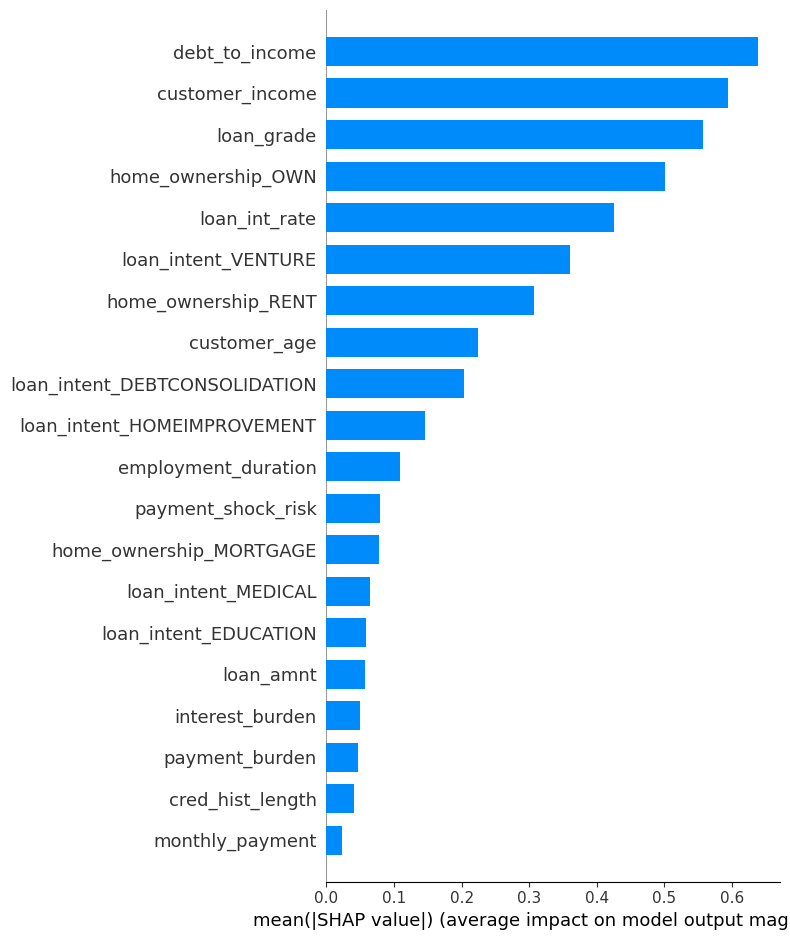


FEATURE EFFECTS (Red=Higher Risk, Blue=Lower Risk)


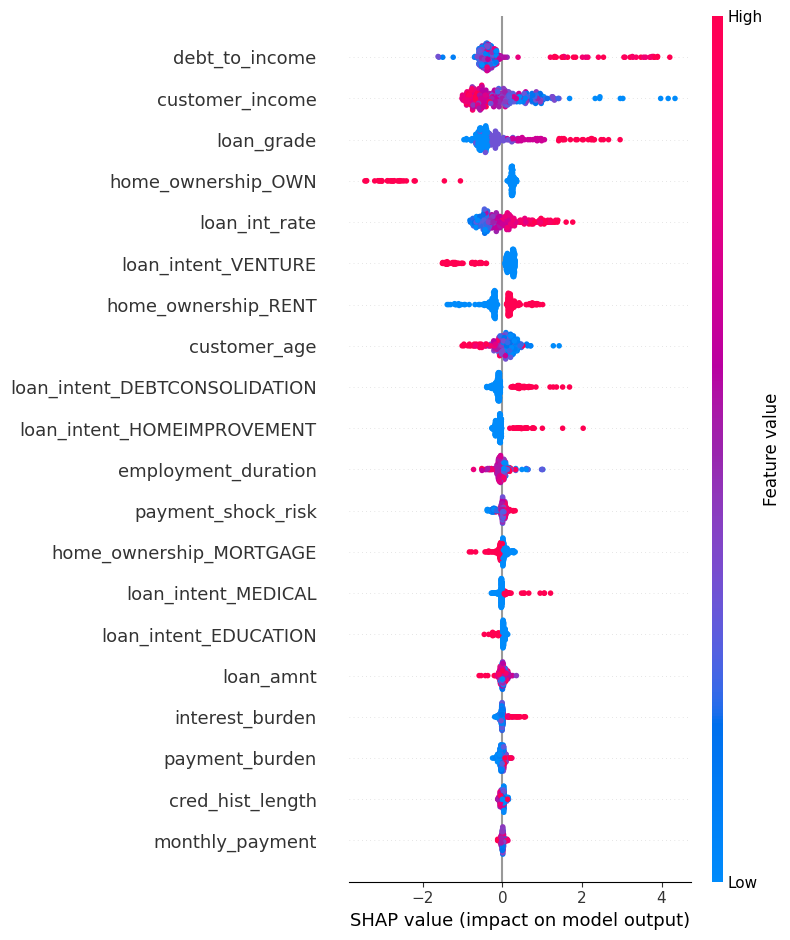


INDIVIDUAL PREDICTION EXPLANATION (Sample Index 0)


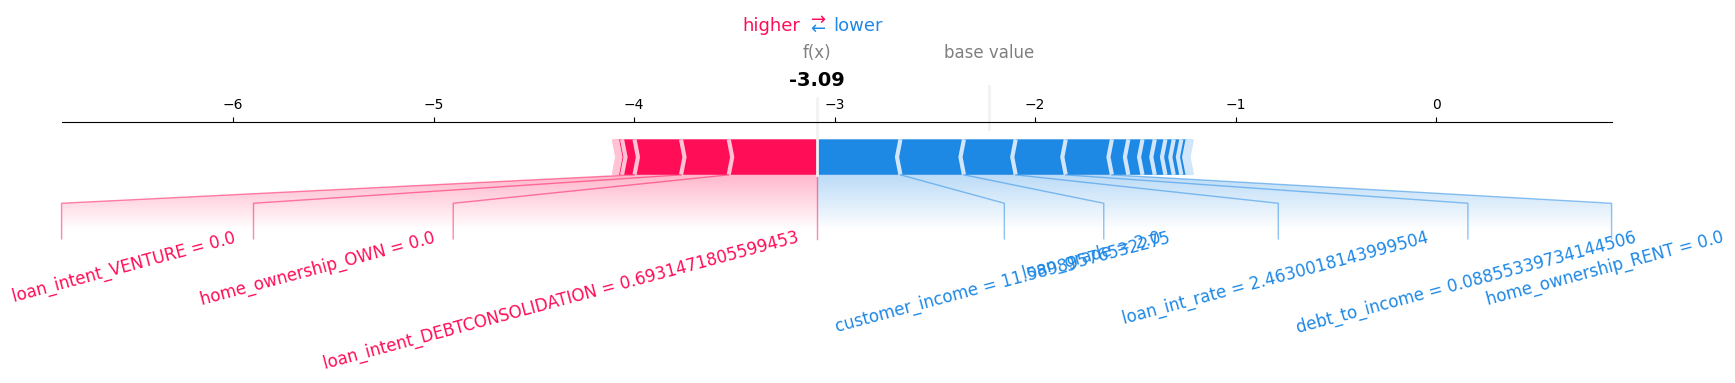

<Figure size 640x480 with 0 Axes>

In [253]:
from utils.ml_functions import explain_with_shap

explain_with_shap(results['best_single_model'], X_test, top_n_features=X_test.columns.shape[0])

#### Performance optimisation

Threshold for Recall ≥ 80%: 0.2290
Precision: 0.7549, Recall: 0.8006


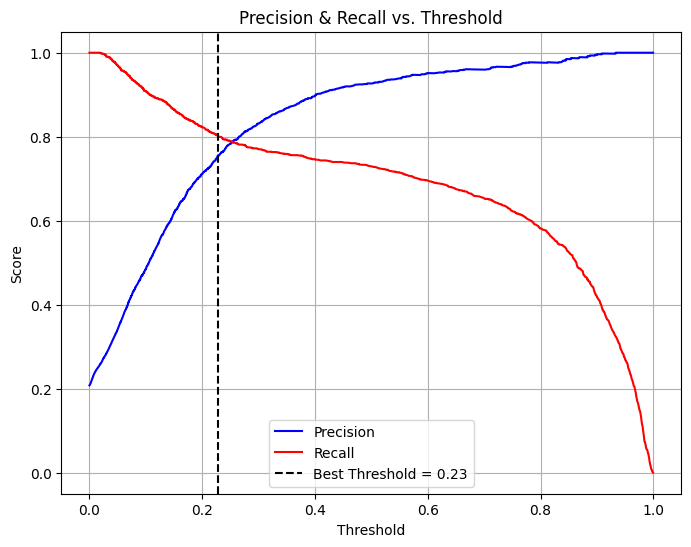

In [244]:
from utils.ml_functions import plot_precision_recall_thresholds

plot_precision_recall_thresholds(results['ensemble'], X_test, y_test, min_recall = 0.8)

#### Business Intelligence

##### Analyzing misleading features

In [245]:
from utils.ml_functions import analyze_false_negatives_misleading_features
analyze_false_negatives_misleading_features(
    results['ensemble'],
    X_test,
    y_test,
    top_n_features=20
)

📊 FALSE NEGATIVE ANALYSIS
False Negatives: 366
True Positives: 988
FN Probability Range: 0.020 - 0.497
FN Mean Probability: 0.175

🚨 TOP 20 MOST MISLEADING FEATURES:
Feature                   Type            FN Mean    TP Mean    %Diff     
--------------------------------------------------------------------------------
home_ownership_MORTGAGE   One-Hot Encoded 0.462      0.138     235.4     %
home_ownership_OWN        One-Hot Encoded 0.011      0.029     -62.8     %
loan_intent_EDUCATION     One-Hot Encoded 0.197      0.122     60.6      %
interest_burden           Numerical       0.056      0.100     -44.6     %
payment_burden            Numerical       0.060      0.096     -38.0     %
home_ownership_RENT       One-Hot Encoded 0.522      0.828     -37.0     %
debt_to_income            Numerical       0.154      0.238     -35.3     %
loan_intent_VENTURE       One-Hot Encoded 0.139      0.107     29.9      %
loan_intent_HOMEIMPROVEMENT One-Hot Encoded 0.096      0.122     -21.9     %
l

In [246]:
# display(list(selected_features) + ['current_loan_status'])
selected_features.columns

Index(['customer_age', 'customer_income', 'loan_grade', 'loan_amnt',
       'term_years', 'cred_hist_length', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'loan_int_rate', 'employment_duration',
       'debt_to_income', 'monthly_payment', 'payment_burden',
       'interest_burden', 'employment_stable', 'payment_shock_risk',
       'age_risk_modifier'],
      dtype='object')

🔍 STARTING DEFAULT PATTERN DISCOVERY

=== DEFAULTER PATTERN ANALYSIS ===
Using 25 pre-selected features
Clean samples: 32453 (dropped 0 rows)
Default rate: 20.9%
Target distribution:
current_loan_status
0.0    25681
1.0     6772
Name: count, dtype: int64

Testing KMeans clustering...
  K=2: Silhouette=0.171, Default Separation=0.141
  K=3: Silhouette=0.170, Default Separation=0.116
  K=4: Silhouette=0.143, Default Separation=0.131
  K=5: Silhouette=0.126, Default Separation=0.146
  K=6: Silhouette=0.122, Default Separation=0.165
  K=7: Silhouette=0.112, Default Separation=0.169

Testing DBSCAN clustering...

Testing Hierarchical clustering...
  Skipping hierarchical (too many samples)

Best model: kmeans (params: 6)
Score: 0.152 (Default Sep: 0.165, Silhouette: 0.122)

DEFAULT PATTERN INSIGHTS

CLUSTER 0 - LOW RISK
Size: 6462 (19.9%)
Default Rate: 13.2%
  home_ownership_MORTGAGE: 0.329 (0.8x lower than average)
  debt_to_income: 0.078 (0.5x lower than average)
  payment_burden: 0.025 (

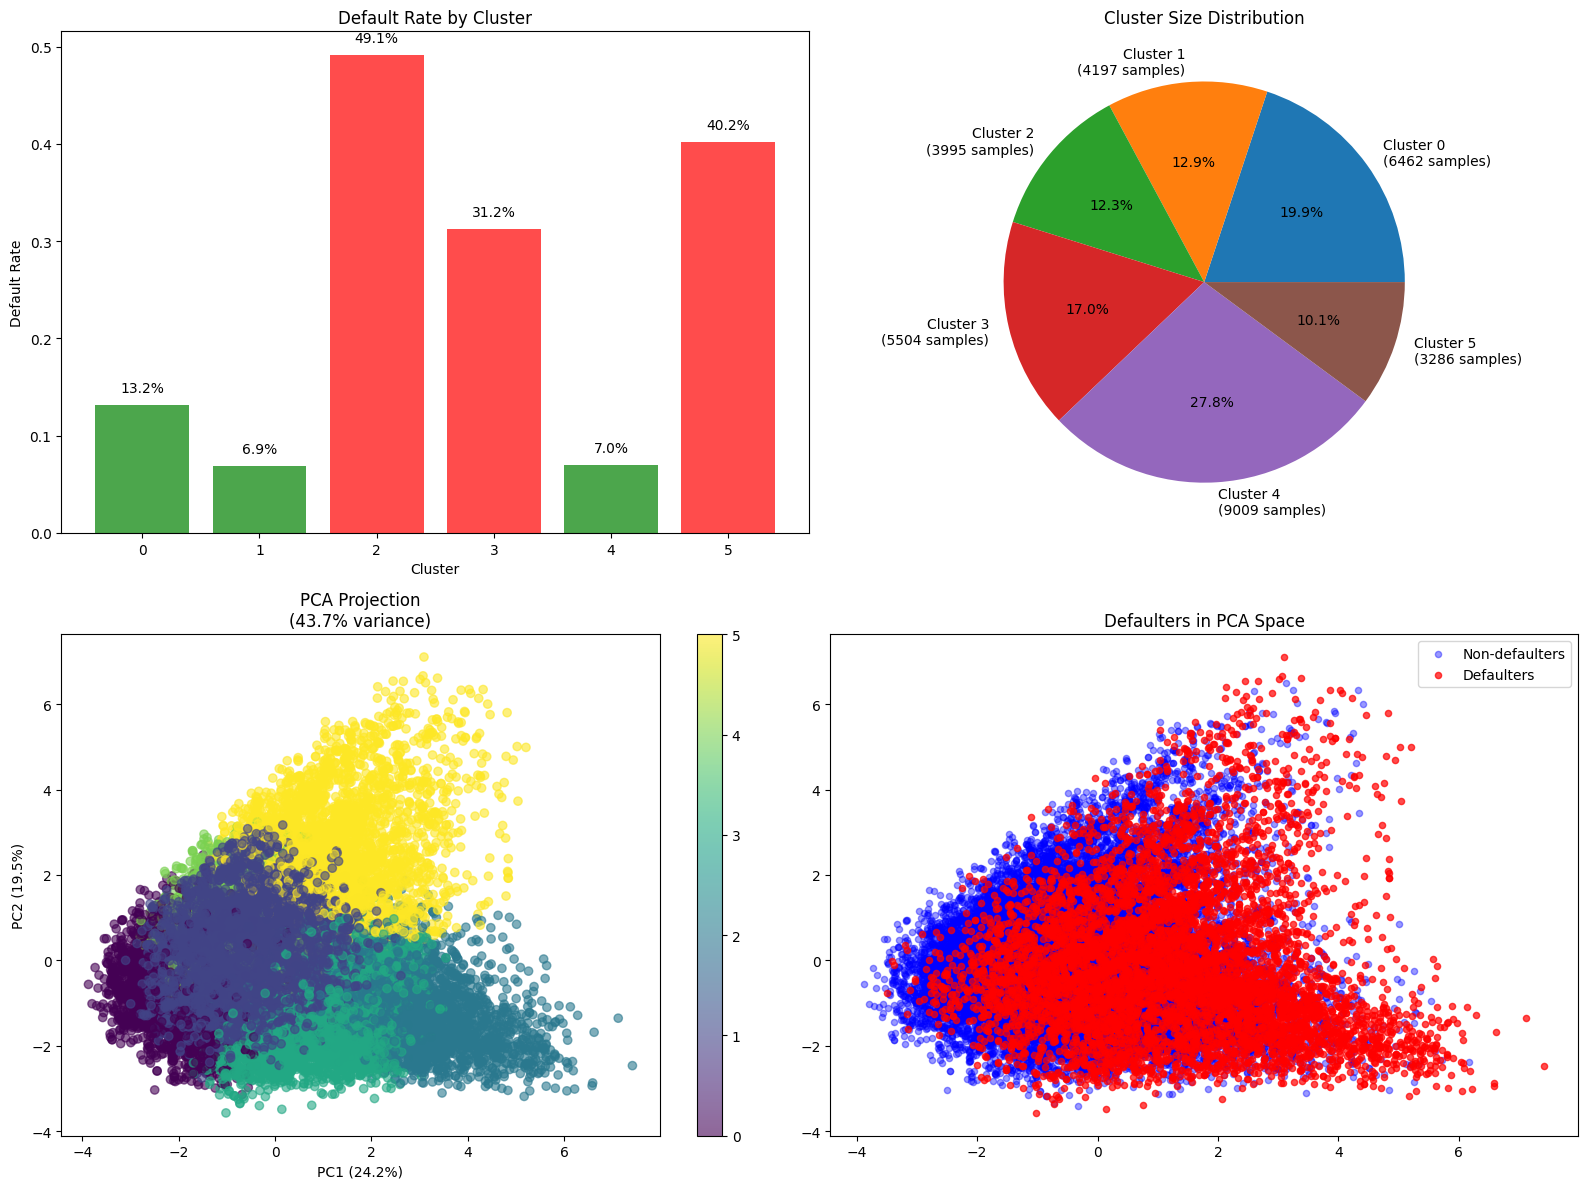

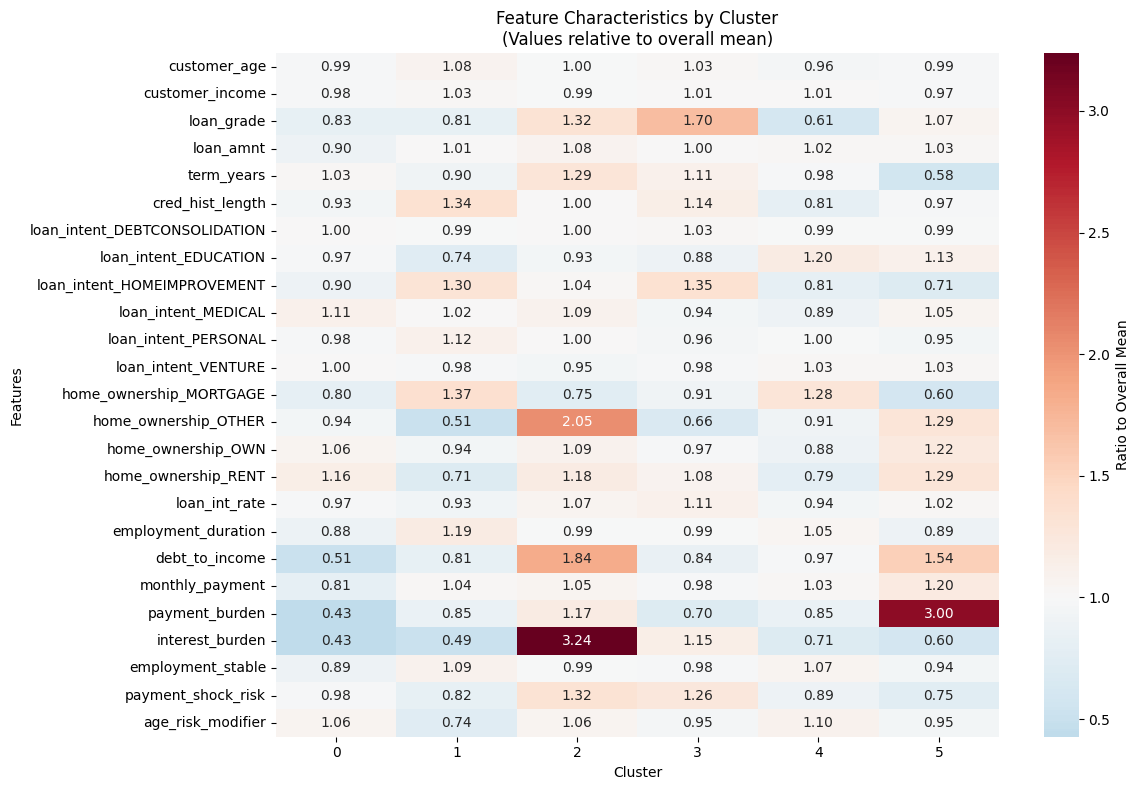


✅ Analysis Complete!
Best clustering method: {'model': KMeans(max_iter=500, n_clusters=6, n_init=20, random_state=42), 'labels': array([0, 2, 5, ..., 1, 2, 1], shape=(32453,), dtype=int32), 'silhouette': np.float64(0.12218353774717286), 'default_separation': np.float64(0.1654269038305502), 'n_clusters': 6}


In [247]:
import importlib
import utils.ml_functions  # Import first
importlib.reload(utils.ml_functions)  # Force-reload
from utils.ml_functions import discover_default_patterns

# Example usage:
analyzer, insights = discover_default_patterns(
    df_encoded_v2,
    feature_columns=list(selected_features),  # You provide the features
    target_col='current_loan_status',
    sampling_strategy='none'
)

<a id="conclusion-and-recommendations"></a>
### Conclusion and Recommendations <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

<h4><b><u>Conclusion</u></b></h4>

- Loan grade is by far the strongest predictor of default risk, followed by previous default history.
- Home rental status, venture loan purposes, and high debt-to-income ratios are significant warning signs.
- Renters present higher default risks compared to homeowners.
- Surprisingly, loan amount and term length are less influential than many traditional factors.
- Venture funding loans carry significantly more risk than personal, medical, or educational loans.
- Age demonstrates some correlation with repayment behavior, with the 30-40 age group showing distinctive patterns.

Click on this <a href='<iframe title="credit_loan_defaulters-v3" width="600" height="373.5" src="https://app.powerbi.com/view?r=eyJrIjoiNjRjMzQ2ZjktMjU2MS00YWMwLTgxYWYtZDc1MDZkMzRmMGM4IiwidCI6IjhjY2M5ZDBkLTA3YmMtNDZlNS05NDg3LTUzNWFiYWY4N2ViMSJ9" frameborder="0" allowFullScreen="true"></iframe>'>link</a> to see a visual report.

<h4><b><u>Recommendations</u></b></h4>

**Lending Strategy:**

- Prioritize loan grade in approval decisions but verify it against actual default history.
- Consider charging higher interest rates for debt consolidation loans and applicants with rental housing status.
- Implement tiered pricing based on risk profiles rather than simple approve/deny decisions.


**Risk Management:**

- Increase verification requirements for high debt-to-income applicants.
- Develop special underwriting guidelines for debt consolidation loans.
- Create an early warning system for loans with multiple risk factors.


**Business Opportunities:**

- Develop specialized loan products for homeowners leveraging their lower default rates.
- Consider educational loan programs as they show lower default tendencies.
- Explore partnership opportunities with real estate companies to offer homebuyer programs that could convert renters to lower-risk homeowners.


**Customer Experience:**

- Offer financial education resources for borderline applicants.
- Create loyalty programs for repeat borrowers with good repayment history.
- Implement a "second chance" program for borrowers with improving credit profiles.


**Future Directions:**

- Test different interest rate structures based on risk levels to maximize profitability while maintaining reasonable approval rates.
- Explore early repayment incentives for higher-risk borrowers.
- Conduct regular review of lending criteria as economic conditions change.